# MATH3219 Course Project
### Group: K-Newest Noobers
#### Benjamin Huang (s3383866), Yoga Pratama Suryanto (s3756007), Anthony Berry (s3372016)

## Table Of Contents

- [1. Overview](#1)
    - [1.1 Introduction](#1.1)
    - [1.2 Methodology](#1.2)
- [2. Load Packages](#2)
- [3. Load & Examine Data](#3)
- [4. Preprocessing](#4)
    - [4.1 Data Types](#4.1)
    - [4.2 Redundant Features](#4.2)
    - [4.3 Incorrect Values](#4.3)
    - [4.4 Missing Values](#4.4)
    - [4.5 Data Aggregation & Irregular Cardinality](#4.5)
        - [4.5.1 Home Ownership Feature](#4.5.1)
        - [4.5.2 Purpose Feature](#4.5.2)
        - [4.5.3 Bankruptcies Feature](#4.5.3)
        - [4.5.4 Tax Liens Feature](#4.5.4)
        - [4.5.5 Number Credit Problems Feature](#4.5.5)
        - [4.5.6 Years Current Job Feature](#4.5.6)
        - [4.5.7 Months Since Last Delinquent Feature](#4.5.7)
        - [4.5.8 Data Aggregation Summary](#4.5.8)
    - [4.6 Outlier](#4.6)
    - [4.7 Target Feature & Data Summary](#4.7)
- [5. Data Exploration](#5)
    - [5.1 Distribution Of Continuous Features](#5.1)
    - [5.2 Correlation Between Continuous Features](#5.2)
    - [5.3 Credit Score By Loan Status](#5.3)
    - [5.4 Current Loan Amount By Loan Status](#5.4)
    - [5.5 Years Of Credit History By Loan Status](#5.5)
    - [5.6 Monthly Debt by Loan Status and Home Ownership](#5.6)
    - [5.7 Loan Term by Loan Status](#5.7)
- [6. Data Encoding](#6)
    - [6.1 Target Feature](#6.1)
    - [6.2 Categorical Features](#6.2)
- [7. Data Scaling](#7)
- [8. Sampling & Train/Test Splitting](#8)
- [9. Hyperparameter & Feature Selection](#9)
    - [9.1 K-Nearest Neighbours](#9.1)
    - [9.2 Decision Tree](#9.2)
    - [9.3 Naive Bayes](#9.3)
    - [9.4 Logistic Regression](#9.4)
    - [9.5 Random Forest](#9.5)
- [10. Model Evaluation & Comparison](#10)
- [11. Discussion](#11)
- [12. Conclusion](#12)

## 1. Overview <a name="1"></a>

### 1.1 Introduction <a name="1.1"></a>

This project will use the 'Bank Loan Status Dataset' uploaded by Zaur Begiev on [Kaggle](https://www.kaggle.com/zaurbegiev/my-dataset?select=credit_train.csv) (Begiev, Z. 2017), which contains lending data for a particular lending institutions's historical accounts that are no longer active - meaning that the accounts have closed either due to the loans having been repaid, or that the loans were written off.

The purpose of this project is to use this bank loan dataset to predict whether a borrower will repay their loans or not based on the dataset's descriptive features. The target feature of interest will be the 'Loan Status', which determines whether a borrower has fully repaid their loan, or have been charged off (when a bank has determined that the borrower will never repay their loan).

### 1.2 Methodology <a name="1.2"></a>

To predict the target feature, the following binary classifiers are considered:
- K-Nearest Neighbours (KNN).
- Decision Tree (DT).
- Naive Bayes (NB).
- Logistic Regression (LR)
- Random Forest (RF).

Before any classifiers are fitted, the full dataset is pre-processed, encoded, and transformed. The encoding process involves converting all of the nominal categorical features into numerical dummy features by process of one-hot-encoding. Similarly, the target feature was encoded such that the positive class of 'Fully Paid' was encoded as `1` and the negative class of 'Charged Off' as `0`. Next, the descriptive features are scaled via standardisation, which changed the features to all have a mean of zero and a standard deviation of one. This is done since scaling is beneficial for distance-based algorithms. Finally, both the data and target sets are further split into training and testing sets with 70 and 30 percent of the observations, respectively. The training sets are used during the hyper-parameter tuning phase while the test sets are used to compare performances. 

The five binary classifiers were then examined in order to find their respective best hyper-parameters and feature set. Feature selection was carried out using the Random Forest Importance (RFI) method for each classifier. As the target feature was highly imbalanced with more observations being recorded as “Fully Paid”, a stratified 5-fold cross-validation with 2 repetitions is used to assist in tuning hyper-parameters appropriate to each classifier. This hyper-parameter search was combined with the RFI feature selection in a single pipeline. The performance metric used to determine optimal the hyper-parameters and feature set was the area under the ROC curve (AUC) score. 

The five tuned classifiers with the best hyper-parameter and feature set values found with the training sets are then fitted onto the test sets via stratified 10-fold cross-validation with 3 repetitions. The AUC score results for each of these optimised classifiers are then compared via paired t-tests to examine if any difference in performance between the classifiers is statistically significant. 

## 2. Load Packages <a name="2"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 110)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 3. Load & Examine Data <a name="3"></a>

The Bank Loan Status dataset is loaded and assigned to `df`. As seen below, the dataset contains 100,514 observations and 19 features. The description of each feature is as follows:
* Loan ID: The unique ID of the loan.
* Customer ID: The unique ID of the customer.
* Loan Status: Whether the loan has been fully repaid or charged off (written off). This is the **target feature**.
* Current Loan Amount: The total loan amount at the time of snapshot. Currency is not specified.
* Term: Whether the loan is a short term or long term loan.
* Credit Score: The customer's credit score. Type of credit score is not specified.
* Annual Income: The customer's self-reported annual income.
* Years Current Job: The self-reported number of years the customer has been working in their current job.
* Home Ownership: Whether the customer is renting, on a mortgage, or owns a home.
* Purpose: Purpose of the loan.
* Monthly Debt: Not defined.
* Years of Credit History: The number of years since public credit information was available for this customer.
* Months Since Last Delinquent: The number of months since the customer's last delinquency. Delinquency is not defined, but is usually 60 or 90 days overdue.
* Number Open Accounts: The number of total open credit accounts (inclusive of all accounts outside of this lending institution).
* Number Credit Problems: The number of total credit problems. Credit problems are not defined.
* Current Credit Balance: Not defined.
* Maximum Open Credit: Not defined.
* Bankruptcies: The number of bankruptcies if the customer has had businesses.
* Tax Liens: The number of tax liens the customer has had.

In [2]:
df = pd.read_csv("credit_train.csv",
                 names=['Loan ID','Customer ID','Loan Status','Current Loan Amount','Term',
                        'Credit Score','Annual Income','Years Current Job','Home Ownership', 
                        'Purpose','Monthly Debt','Years of Credit History',
                        'Months Since Last Delinquent','Number Open Accounts',
                        'Number Credit Problems','Current Credit Balance','Maximum Open Credit', 
                        'Bankruptcies','Tax Liens'],
                 header=0)

In [3]:
df.head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.000,Short Term,709.000,1167493.000,8 years,Home Mortgage,Home Improvements,5214.740,17.200,nan,6.000,1.000,228190.000,416746.000,1.000,0.000
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.000,Short Term,nan,nan,10+ years,Home Mortgage,Debt Consolidation,33295.980,21.100,8.000,35.000,0.000,229976.000,850784.000,0.000,0.000
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.000,Short Term,741.000,2231892.000,8 years,Own Home,Debt Consolidation,29200.530,14.900,29.000,18.000,1.000,297996.000,750090.000,0.000,0.000
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.000,Long Term,721.000,806949.000,3 years,Own Home,Debt Consolidation,8741.900,12.000,nan,9.000,0.000,256329.000,386958.000,0.000,0.000
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.000,Short Term,nan,nan,5 years,Rent,Debt Consolidation,20639.700,6.100,nan,15.000,0.000,253460.000,427174.000,0.000,0.000
5,89d8cb0c-e5c2-4f54-b056-48a645c543dd,4ffe99d3-7f2a-44db-afc1-40943f1f9750,Charged Off,206602.000,Short Term,7290.000,896857.000,10+ years,Home Mortgage,Debt Consolidation,16367.740,17.300,nan,6.000,0.000,215308.000,272448.000,0.000,0.000
6,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.000,Short Term,730.000,1184194.000,< 1 year,Home Mortgage,Debt Consolidation,10855.080,19.600,10.000,13.000,1.000,122170.000,272052.000,1.000,0.000
7,db0dc6e1-77ee-4826-acca-772f9039e1c7,018973c9-e316-4956-b363-67e134fb0931,Charged Off,648714.000,Long Term,nan,nan,< 1 year,Home Mortgage,Buy House,14806.130,8.200,8.000,15.000,0.000,193306.000,864204.000,0.000,0.000
8,8af915d9-9e91-44a0-b5a2-564a45c12089,af534dea-d27e-4fd6-9de8-efaa52a78ec0,Fully Paid,548746.000,Short Term,678.000,2559110.000,2 years,Rent,Debt Consolidation,18660.280,22.600,33.000,4.000,0.000,437171.000,555038.000,0.000,0.000
9,0b1c4e3d-bd97-45ce-9622-22732fcdc9a0,235c4a43-dadf-483d-aa44-9d6d77ae4583,Fully Paid,215952.000,Short Term,739.000,1454735.000,< 1 year,Rent,Debt Consolidation,39277.750,13.900,nan,20.000,0.000,669560.000,1021460.000,0.000,0.000


In [4]:
df.shape

(100514, 19)

## 4. Preprocessing <a name="4"></a>

### 4.1 Data Types <a name="4.1"></a>

Looking at the data types for each feature below, 'Loan Status', 'Term', 'Years Current Job', 'Home Ownership', and 'Purpose' are objects, while the remaining features are floats. This is not entirely appropriate as 'Months Since Last Delinquent', 'Number Credit Problems', 'Bankruptcies', and 'Tax Liens' are ordinal features and should not be floats. This will be dealt with in later sections. Additionally, loan and customer IDs are objects due to containing letters, however they will be examined more closely in the next section.

In [5]:
df.dtypes

Loan ID                          object
Customer ID                      object
Loan Status                      object
Current Loan Amount             float64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years Current Job                object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months Since Last Delinquent    float64
Number Open Accounts            float64
Number Credit Problems          float64
Current Credit Balance          float64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object

### 4.2 Redundant Features <a name="4.2"></a>

Looking at the number of unique values for each feature, there doesn't seem to exist any constant features, however
there does exist an issue in which 'Loan ID' and 'Customer ID' are not comprised of completely unique values, since both of them contain 81,999 unique values as opposed to the expected 100,514. This means that there exist some customers who have more than one entry in the dataset, which may need to be dealt with.

In [6]:
df.nunique()

Loan ID                         81999
Customer ID                     81999
Loan Status                         2
Current Loan Amount             22004
Term                                2
Credit Score                      324
Annual Income                   36174
Years Current Job                  11
Home Ownership                      4
Purpose                            16
Monthly Debt                    65765
Years of Credit History           506
Months Since Last Delinquent      116
Number Open Accounts               51
Number Credit Problems             14
Current Credit Balance          32730
Maximum Open Credit             44596
Bankruptcies                        8
Tax Liens                          12
dtype: int64

First, the duplicated 'Customer ID' rows are examined. It can be seen that each 'Customer ID' has an associated 'Loan ID', indicating that each customer only has one loan, and each loan only has one customer. This means that there is no reason for duplicate customer IDs or loan IDs to exist.

In [7]:
index = df['Customer ID'].value_counts()[df['Customer ID'].value_counts()>1].index.values
df[df['Customer ID'].isin(index)].sort_values('Customer ID').head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
11148,f122c3f1-08ef-439e-912a-449802deb2a1,000877d4-55ed-4126-abda-968f61da7b7f,Fully Paid,111584.000,Short Term,717.000,481802.000,5 years,Rent,Debt Consolidation,5098.840,8.600,nan,5.000,0.000,103398.000,174020.000,0.000,0.000
33099,f122c3f1-08ef-439e-912a-449802deb2a1,000877d4-55ed-4126-abda-968f61da7b7f,Fully Paid,111584.000,Short Term,nan,nan,5 years,Rent,Debt Consolidation,5098.840,8.600,nan,5.000,0.000,103398.000,174020.000,0.000,0.000
39664,e4deec6d-406f-4873-bbdf-46f252c0b92c,0008bc47-41f5-4e2b-b656-db39bc194a01,Fully Paid,270974.000,Long Term,623.000,765700.000,< 1 year,Rent,Debt Consolidation,12889.220,9.500,nan,7.000,0.000,235809.000,447612.000,0.000,0.000
93526,e4deec6d-406f-4873-bbdf-46f252c0b92c,0008bc47-41f5-4e2b-b656-db39bc194a01,Fully Paid,270974.000,Long Term,623.000,765700.000,< 1 year,Rent,Debt Consolidation,12889.220,9.500,nan,7.000,0.000,235809.000,447612.000,0.000,0.000
92361,87b6a064-b524-4cff-a968-b176bdc70075,000bbb5d-3a62-4712-908e-caacd7a815d5,Fully Paid,731082.000,Short Term,nan,nan,2 years,Rent,Debt Consolidation,25351.320,17.700,nan,13.000,0.000,722095.000,1509244.000,0.000,0.000
81139,87b6a064-b524-4cff-a968-b176bdc70075,000bbb5d-3a62-4712-908e-caacd7a815d5,Fully Paid,731082.000,Short Term,708.000,1913300.000,2 years,Rent,Debt Consolidation,25351.320,17.700,nan,13.000,0.000,722095.000,1509244.000,0.000,0.000
89966,54bd20d4-3baf-4143-afc5-b6db9300a14d,00127cca-7050-4867-9410-8249ef8ad4d2,Fully Paid,343464.000,Long Term,720.000,1140912.000,10+ years,Home Mortgage,Home Improvements,9431.600,19.800,30.000,8.000,0.000,48032.000,617958.000,0.000,0.000
47215,54bd20d4-3baf-4143-afc5-b6db9300a14d,00127cca-7050-4867-9410-8249ef8ad4d2,Fully Paid,343464.000,Long Term,720.000,1140912.000,10+ years,Home Mortgage,Home Improvements,9431.600,19.800,30.000,8.000,0.000,48032.000,617958.000,0.000,0.000
70953,c6e62921-023d-4033-9805-0179cde0de33,00132610-2f2f-4aeb-a371-2d66aca1248e,Fully Paid,288024.000,Long Term,697.000,1243778.000,8 years,Home Mortgage,Debt Consolidation,12002.300,19.700,10.000,9.000,0.000,40736.000,130680.000,0.000,0.000
40102,c6e62921-023d-4033-9805-0179cde0de33,00132610-2f2f-4aeb-a371-2d66aca1248e,Fully Paid,99999999.000,Long Term,697.000,1243778.000,8 years,Home Mortgage,Debt Consolidation,12002.300,19.700,10.000,9.000,0.000,40736.000,130680.000,0.000,0.000


Looking at the number of duplicated rows (across all features), there are 20,944. These duplicated rows are then removed, leaving 89,786 observations in the dataset.

In [8]:
print("Number of duplicated rows:", len(df[df.duplicated(keep=False)]))
df = df.drop_duplicates()
print("Number of rows in df after duplicates are removed:", df.shape[0])

Number of duplicated rows: 20944
Number of rows in df after duplicates are removed: 89786


The next step is to examine whether 'Customer ID' still contain values that occur more than once, which reveals 15,572 observations. Examining the table below, it seems that the duplicate customer IDs have mostly the same values across features, however with 'Credit Score' and 'Annual Income' containing `NaN` values as opposed to being populated. Additionally, the 'Current Loan Amount' values for some duplicates are `99999999.0` which indicates some form of non-applicable value.

In [9]:
index = df['Customer ID'].value_counts()[df['Customer ID'].value_counts()>1].index.values
df_dup = df[df['Customer ID'].isin(index)].sort_values('Customer ID')

print("df_dup Shape:", df_dup.shape)
df_dup.head(10)

df_dup Shape: (15572, 19)


,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
33099,f122c3f1-08ef-439e-912a-449802deb2a1,000877d4-55ed-4126-abda-968f61da7b7f,Fully Paid,111584.000,Short Term,nan,nan,5 years,Rent,Debt Consolidation,5098.840,8.600,nan,5.000,0.000,103398.000,174020.000,0.000,0.000
11148,f122c3f1-08ef-439e-912a-449802deb2a1,000877d4-55ed-4126-abda-968f61da7b7f,Fully Paid,111584.000,Short Term,717.000,481802.000,5 years,Rent,Debt Consolidation,5098.840,8.600,nan,5.000,0.000,103398.000,174020.000,0.000,0.000
92361,87b6a064-b524-4cff-a968-b176bdc70075,000bbb5d-3a62-4712-908e-caacd7a815d5,Fully Paid,731082.000,Short Term,nan,nan,2 years,Rent,Debt Consolidation,25351.320,17.700,nan,13.000,0.000,722095.000,1509244.000,0.000,0.000
81139,87b6a064-b524-4cff-a968-b176bdc70075,000bbb5d-3a62-4712-908e-caacd7a815d5,Fully Paid,731082.000,Short Term,708.000,1913300.000,2 years,Rent,Debt Consolidation,25351.320,17.700,nan,13.000,0.000,722095.000,1509244.000,0.000,0.000
40102,c6e62921-023d-4033-9805-0179cde0de33,00132610-2f2f-4aeb-a371-2d66aca1248e,Fully Paid,99999999.000,Long Term,697.000,1243778.000,8 years,Home Mortgage,Debt Consolidation,12002.300,19.700,10.000,9.000,0.000,40736.000,130680.000,0.000,0.000
70953,c6e62921-023d-4033-9805-0179cde0de33,00132610-2f2f-4aeb-a371-2d66aca1248e,Fully Paid,288024.000,Long Term,697.000,1243778.000,8 years,Home Mortgage,Debt Consolidation,12002.300,19.700,10.000,9.000,0.000,40736.000,130680.000,0.000,0.000
80729,136fe944-059d-4a9a-8780-bc0e292c8c0c,002bc5f8-d5a8-4829-a6ca-5c624c9d15e6,Fully Paid,779482.000,Short Term,655.000,1711805.000,2 years,Home Mortgage,Debt Consolidation,24678.340,21.900,12.000,14.000,0.000,177707.000,233816.000,0.000,0.000
73064,136fe944-059d-4a9a-8780-bc0e292c8c0c,002bc5f8-d5a8-4829-a6ca-5c624c9d15e6,Fully Paid,99999999.000,Short Term,655.000,1711805.000,2 years,Home Mortgage,Debt Consolidation,24678.340,21.900,12.000,14.000,0.000,177707.000,233816.000,0.000,0.000
35968,b26e56aa-64e2-4a94-97f6-476a832a8d72,002c8210-0d81-4ce4-adca-ae2e4a83ac24,Fully Paid,576180.000,Long Term,719.000,1132020.000,7 years,Home Mortgage,Debt Consolidation,23395.080,21.200,nan,11.000,0.000,198018.000,406516.000,0.000,0.000
2759,b26e56aa-64e2-4a94-97f6-476a832a8d72,002c8210-0d81-4ce4-adca-ae2e4a83ac24,Fully Paid,99999999.000,Long Term,719.000,1132020.000,7 years,Home Mortgage,Debt Consolidation,23395.080,21.200,nan,11.000,0.000,198018.000,406516.000,0.000,0.000


As it is desirable to keep the 'Customer ID' duplicates that **do not** contain NaN values for 'Credit Score' and 'Annual Income', as well as **not** containing `99999999.0` for its 'Current Loan Amount', an index is created that contains all the duplicate customer IDs that do have these values, which is then used to remove these rows from the dataset. Once the undesired duplicates are removed, the `df` contains 82,000 observations.

In [10]:
dup_index = df_dup.sort_values(['Credit Score','Current Loan Amount'], 
                               ascending=True).drop_duplicates(subset='Customer ID',keep = 'last').index.values

df = df.drop(dup_index,axis=0).reset_index(drop=True)
df.shape

(82000, 19)

The code below double checks that there are no more non-unique 'Customer ID' values.

In [11]:
print("Non-Unique Customer ID Values:", len(df['Customer ID'].value_counts()[df['Customer ID'].value_counts()>1]))

Non-Unique Customer ID Values: 0


Now that 'Customer ID' and 'Loan ID' both comprise of entirely unique values, these features can be removed as they do not contain useful information.

In [12]:
df = df.drop(columns=['Loan ID', 'Customer ID'])
df.shape

(82000, 17)

Another issue may arise from two or more of the features containing the same information. From below, it can be seen that 'Loan Status' (the target feature) and 'Term' contain the same number of unique values (levels). Although they're unlikely to contain the same information, a check will still be applied.

In [13]:
df.nunique()

Loan Status                         2
Current Loan Amount             22004
Term                                2
Credit Score                      324
Annual Income                   36174
Years Current Job                  11
Home Ownership                      4
Purpose                            16
Monthly Debt                    65765
Years of Credit History           506
Months Since Last Delinquent      116
Number Open Accounts               51
Number Credit Problems             14
Current Credit Balance          32730
Maximum Open Credit             44596
Bankruptcies                        8
Tax Liens                          12
dtype: int64

The check below indicates that 'Loan Status' and 'Term' do not contain the same information as each other.

In [14]:
status = df['Loan Status'].copy()
term = df['Term'].copy()

term = term.replace({'Short Term':'Fully Paid', 'Long Term': 'Charged Off'})
print("Loan Status:\n", status.head(10).values)
print("Term (Converted):\n", term.head(10).values)

print("\n'Loan Status' and 'Term' are the same:", status.equals(term))

Loan Status:
 ['Fully Paid' 'Fully Paid' 'Fully Paid' 'Fully Paid' 'Charged Off'
 'Fully Paid' 'Charged Off' 'Fully Paid' 'Fully Paid' 'Fully Paid']
Term (Converted):
 ['Fully Paid' 'Fully Paid' 'Fully Paid' 'Charged Off' 'Fully Paid'
 'Fully Paid' 'Charged Off' 'Fully Paid' 'Fully Paid' 'Fully Paid']

'Loan Status' and 'Term' are the same: False


### 4.3 Incorrect Values <a name="4.3"></a>

Looking at the summary statistics of the numerical features below, 'Current Loan Amount' seems suspicious as it contains maximum values of `99999999.0`. Additionally, 'Credit Score' also seems suspicious because the values in the quartiles (min, 25%, 50%, and 75%) indicate that the credit score may be FICO scores, however its max value would be impossible.

In [15]:
df.describe(include=np.number)

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,81999.000,67052.000,67052.000,81999.000,81999.000,37378.000,81999.000,81999.000,81999.000,81997.000,81824.000,81991.000
mean,9919200.241,1153.858,1376503.129,18330.633,18.297,35.064,11.114,0.161,293620.313,793535.814,0.113,0.028
std,29424012.469,1609.162,1113132.317,12127.701,7.044,22.021,4.981,0.473,372614.512,9208747.412,0.345,0.255
min,10802.000,585.000,76627.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,177804.000,710.000,847860.750,10117.595,13.500,16.000,8.000,0.000,113316.000,280456.000,0.000,0.000
50%,298518.000,730.000,1170628.000,16075.330,17.000,32.000,10.000,0.000,209931.000,477774.000,0.000,0.000
75%,483714.000,743.000,1649257.000,23811.370,21.800,51.000,14.000,0.000,366994.500,798490.000,0.000,0.000
max,99999999.000,7510.000,165557393.000,435843.280,70.500,176.000,76.000,15.000,32878968.000,1539737892.000,7.000,15.000


Exploring the `99999999.0` values further reveals that these values only occur for loan statuses that are fully paid, which means that this value could represent some non-applicable value, hence will be converted to `NaN`.

In [16]:
df['Loan Status'][df['Current Loan Amount'] == 99999999].value_counts()

Fully Paid    7905
Name: Loan Status, dtype: int64

In [17]:
df.replace(99999999,np.nan, inplace=True)
df.describe(include=np.number)

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,74094.000,67052.000,67052.000,81999.000,81999.000,37378.000,81999.000,81999.000,81999.000,81997.000,81824.000,81991.000
mean,308587.855,1153.858,1376503.129,18330.633,18.297,35.064,11.114,0.161,293620.313,793535.814,0.113,0.028
std,183154.098,1609.162,1113132.317,12127.701,7.044,22.021,4.981,0.473,372614.512,9208747.412,0.345,0.255
min,10802.000,585.000,76627.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,171974.000,710.000,847860.750,10117.595,13.500,16.000,8.000,0.000,113316.000,280456.000,0.000,0.000
50%,265672.000,730.000,1170628.000,16075.330,17.000,32.000,10.000,0.000,209931.000,477774.000,0.000,0.000
75%,429792.000,743.000,1649257.000,23811.370,21.800,51.000,14.000,0.000,366994.500,798490.000,0.000,0.000
max,789250.000,7510.000,165557393.000,435843.280,70.500,176.000,76.000,15.000,32878968.000,1539737892.000,7.000,15.000


For 'Credit Score', any value over `850` is examined (because the maximum value of a FICO score is 850), which returns 4,538 observations.

In [18]:
fico = df['Credit Score'][df['Credit Score']>850]
fico

4       7290.000
39      7120.000
47      6610.000
52      7380.000
61      7370.000
          ...   
81887   7420.000
81906   7070.000
81932   6880.000
81963   6790.000
81965   6940.000
Name: Credit Score, Length: 4551, dtype: float64

In [19]:
len(fico)

4551

It seems that a lot of these values are in the thousands. It could be that an extra zero had been incorrectly added to the end of these values. To support this idea, the values between 3,000 and 8,500 are counted (since FICO scores range between 300 to 850) to see if all observations over 850 fall into this range. This returns 4,538 observations, meaning that all values larger 850 are between 3,000 and 8,500. Given this, it is highly likely that 'Credit Score' is measured in FICO scores, hence these values will be divided by ten to return them to their correct score.

In [20]:
len(fico[(fico>=300)&(fico<=8500)])

4551

In [21]:
index = fico.index.values
df['Credit Score'][index] = df['Credit Score'][index] / 10
df.describe(include=np.number)

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Number Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,74094.000,67052.000,67052.000,81999.000,81999.000,37378.000,81999.000,81999.000,81999.000,81997.000,81824.000,81991.000
mean,308587.855,719.603,1376503.129,18330.633,18.297,35.064,11.114,0.161,293620.313,793535.814,0.113,0.028
std,183154.098,27.918,1113132.317,12127.701,7.044,22.021,4.981,0.473,372614.512,9208747.412,0.345,0.255
min,10802.000,585.000,76627.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,171974.000,707.000,847860.750,10117.595,13.500,16.000,8.000,0.000,113316.000,280456.000,0.000,0.000
50%,265672.000,727.000,1170628.000,16075.330,17.000,32.000,10.000,0.000,209931.000,477774.000,0.000,0.000
75%,429792.000,740.000,1649257.000,23811.370,21.800,51.000,14.000,0.000,366994.500,798490.000,0.000,0.000
max,789250.000,751.000,165557393.000,435843.280,70.500,176.000,76.000,15.000,32878968.000,1539737892.000,7.000,15.000


Additionally, the maximum value of `165557393.000` for 'Annual Income', `32878968.000` for 'Current Credit Balance', `435843.280` for 'Monthly Debt', and `1539737892.000` for 'Maximum Open Credit' all seem suspicious. However due to the fact that the currency or country this dataset is based on is unknown, combined with the fact that no descriptions have been provided for what 'Current Credit Balance', 'Monthly Debt' and 'Maximum Open Credit' represent, it is impossible to determine whether these outliers are due to entry errors or that they are real values. These values will be examined further in the 'Outlier' section.

### 4.4 Missing Values <a name="4.4"></a>

Looking at the number of missing values for each feature below, two aspects draw attention: 
1. There is 1 missing value in the 'Loan Status' target feature.
2. Both 'Credit Score' and 'Annual Income' have the same number of missing values.

In [22]:
df.isna().sum()

Loan Status                         1
Current Loan Amount              7906
Term                                1
Credit Score                    14948
Annual Income                   14948
Years Current Job                3509
Home Ownership                      1
Purpose                             1
Monthly Debt                        1
Years of Credit History             1
Months Since Last Delinquent    44622
Number Open Accounts                1
Number Credit Problems              1
Current Credit Balance              1
Maximum Open Credit                 3
Bankruptcies                      176
Tax Liens                           9
dtype: int64

The code below removes the missing value in the target feature as it will not be useful for machine learning.

In [23]:
df = df[df['Loan Status'].notnull()]
df.shape

(81999, 17)

Looking at the observations with missing values from both 'Credit Score' and 'Annual Income' reveals that they share 14,947 missing values. Given that these missing values represent around 18% of the dataset, they will not be imputed due to the large bias it will cause. Furthermore, these missing values cannot act as a level in itself due to these two features being continuous. This means that the missing value observations will be removed.

In [24]:
index = df[(df['Credit Score'].isnull()) & (df['Annual Income'].isnull())].index.values
print("Missing values for Credit Score & Annual Income:", index.shape[0])

df = df.drop(index, axis=0)
print("df shape once missing values are removed:", df.shape)

Missing values for Credit Score & Annual Income: 14947
df shape once missing values are removed: (67052, 17)


Once those two problems have been dealt with, the list below show that the remaining features with missing values are:
* **Current Loan Amount**: These were originally the `99999999.0` values. Because this is a continuous feature and comprises of nearly 12% of the dataset, these missing observations will be removed.
* **Years Current Job**: The `NaN` values in this feature will remain in the dataset to be dealt with in the following section. This is due to the feature being a self-reported value, hence any non-response missing value may still contain useful information.
* **Months Since Last Delinquent**: The `NaN` values in this feature represent more than half the dataset. However these `NaN` values contain valuable information in that they represent customers who have never had a delinquency. This will be dealt with in the following section.
* **Maximum Open Credit**: Given only 1 missing observation, this observation will be removed.
* **Bankruptcies**: Given only 140 observations, these observations will be removed.
* **Tax Liens**: Given only 5 observations, these observation will be removed.

In [25]:
df.isna().sum()

Loan Status                         0
Current Loan Amount              7905
Term                                0
Credit Score                        0
Annual Income                       0
Years Current Job                2856
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months Since Last Delinquent    36132
Number Open Accounts                0
Number Credit Problems              0
Current Credit Balance              0
Maximum Open Credit                 1
Bankruptcies                      140
Tax Liens                           5
dtype: int64

The observations with missing values found in 'Current Loan Amount', 'Maximum Open Credit', 'Bankruptcies', and 'Tax Liens' are removed. This leaves the missing values in the two categorical features to be dealt with in the next section.

In [26]:
df = df[(df['Current Loan Amount'].notnull()) & (df['Maximum Open Credit'].notnull()) &
        (df['Bankruptcies'].notnull()) & (df['Tax Liens'].notnull())]

df.isna().sum()

Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                        0
Annual Income                       0
Years Current Job                2564
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months Since Last Delinquent    31516
Number Open Accounts                0
Number Credit Problems              0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                        0
Tax Liens                           0
dtype: int64

### 4.5 Data Aggregation & Irregular Cardinality <a name="4.5"></a>

First, 'Months Since Last Delinquent', 'Number Credit Problems', 'Bankruptcies', and 'Tax Liens' will be converted to objects to properly represent their categorical data types.

In [27]:
df['Months Since Last Delinquent'] = df['Months Since Last Delinquent'].astype(str)
df['Number Credit Problems'] = df['Number Credit Problems'].astype(str)
df['Bankruptcies'] = df['Bankruptcies'].astype(str)
df['Tax Liens'] = df['Tax Liens'].astype(str)

print('Months Since Last Delinquent dtype:', df['Months Since Last Delinquent'].dtypes)
print('Number Credit Problems dtype:',df['Number Credit Problems'].dtypes)
print('Bankruptcies dtype:',df['Bankruptcies'].dtypes)
print('Tax Liens dtype:',df['Tax Liens'].dtypes)

Months Since Last Delinquent dtype: object
Number Credit Problems dtype: object
Bankruptcies dtype: object
Tax Liens dtype: object


As seen in the table below, 'Years Current Job', 'Purpose', 'Months Since Last Delinquent', 'Number Credit Problems', 'Bankruptcies', and 'Tax Liens' all have a large number of levels. These will be explored one by one to determine if any aggregation is required.

In [28]:
df.describe(include = np.object)

,Loan Status,Term,Years Current Job,Home Ownership,Purpose,Months Since Last Delinquent,Number Credit Problems,Bankruptcies,Tax Liens
count,59025,59025,56461,59025,59025,59025,59025,59025,59025
unique,2,2,11,4,16,106,14,8,12
top,Fully Paid,Short Term,10+ years,Home Mortgage,Debt Consolidation,nan,0.0,0.0,0.0
freq,41854,42266,18361,28466,46478,31516,50891,52603,57893


Examining the levels for each of the categorical features, 'Home Ownership' seems to have an unusual 'HaveMortgage' level, while 'Purpose' contains numerous cases of irregular cardinality.

In [29]:
cat_var = ['Term','Years Current Job','Home Ownership','Purpose','Months Since Last Delinquent',
           'Number Open Accounts','Number Credit Problems','Bankruptcies','Tax Liens']

for i in cat_var:
    print(i, 'Levels:')
    print(df[i].unique().tolist(),'\n')

Term Levels:
['Short Term', 'Long Term'] 

Years Current Job Levels:
['8 years', '3 years', '10+ years', '< 1 year', '2 years', '4 years', '5 years', '1 year', '7 years', '6 years', '9 years', nan] 

Home Ownership Levels:
['Home Mortgage', 'Own Home', 'Rent', 'HaveMortgage'] 

Purpose Levels:
['Home Improvements', 'Debt Consolidation', 'Buy House', 'other', 'major_purchase', 'Take a Trip', 'Other', 'Business Loan', 'Buy a Car', 'small_business', 'Medical Bills', 'vacation', 'Educational Expenses', 'wedding', 'moving', 'renewable_energy'] 

Months Since Last Delinquent Levels:
['nan', '10.0', '33.0', '46.0', '34.0', '53.0', '30.0', '21.0', '50.0', '15.0', '6.0', '13.0', '48.0', '42.0', '7.0', '27.0', '5.0', '32.0', '17.0', '72.0', '65.0', '4.0', '11.0', '35.0', '24.0', '19.0', '73.0', '60.0', '77.0', '18.0', '9.0', '80.0', '70.0', '38.0', '47.0', '82.0', '74.0', '16.0', '61.0', '75.0', '79.0', '62.0', '56.0', '64.0', '36.0', '59.0', '55.0', '54.0', '37.0', '58.0', '68.0', '22.0', '45.0

#### 4.5.1 Home Ownership Feature <a name="4.5.1"></a>
The level 'HaveMortgage' is very likely to be the same as 'Home Mortgage', however this is examined more closely by checking the proportion of 'Charged Off' occurrences (from the target feature) for each 'Home Ownership' level. 

In [30]:
home_ownership_levels = ['Home Mortgage', 'Own Home', 'Rent', 'HaveMortgage']

df_home = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in home_ownership_levels:
    prop = round(df['Loan Status'][df['Home Ownership'] == i].value_counts()[1]/
                 len(df['Loan Status'][df['Home Ownership'] == i]), 3)
    df_home = df_home.append({'Level':i, 
                              'Prop Charged Off':prop, 
                              'n': len(df[df['Home Ownership']==i])}, ignore_index=True)
    
df_home.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
3,HaveMortgage,0.192,125
0,Home Mortgage,0.264,28466
1,Own Home,0.296,5454
2,Rent,0.321,24980


It seems that the proportion of 'Charged Off' is much lower in 'HaveMortgage' compared to the other levels. However, it must be noted that the amount of observations is very low for this level with only 125 observations, hence it is uncertain whether this difference is significant. Given this, it is decided that 'HaveMortage' will be combined with 'Home Mortgage'.

In [31]:
df['Home Ownership'] = df['Home Ownership'].replace('HaveMortgage', 'Home Mortgage')
df['Home Ownership'].value_counts()

Home Mortgage    28591
Rent             24980
Own Home          5454
Name: Home Ownership, dtype: int64

#### 4.5.2 Purpose Feature <a name="4.5.2"></a>
The 'Purpose' feature has three irregular cardinalities stemming from the following levels:
* 'Business Loan' and 'small_business' both serve the same purpose, hence 'small_business' will become 'Business Loan'.
* 'Other' and 'other' are definitely the same, hence 'other' will become 'Other'.
* 'Take a Trip' and 'vacation' serve the same purpose, hence 'Take a Trip' will become 'vacation'.

In [32]:
df['Purpose'] = df['Purpose'].replace({'small_business':'Business Loan','other':'Other','Take a Trip':'vacation'})
df['Purpose'].value_counts()

Debt Consolidation      46478
Other                    5439
Home Improvements        3398
Business Loan            1121
Buy a Car                 743
Medical Bills             645
Buy House                 396
vacation                  382
major_purchase            215
moving                     90
wedding                    57
Educational Expenses       55
renewable_energy            6
Name: Purpose, dtype: int64

Since the 'Purpose' feature still contains 13 levels, its levels will be aggregated into smaller groups based on their proportion of 'Charged Off' instances for the target feature. For example based on the table below, 'Buy a Car' and 'Educational Expenses' have very similar 'Charged Off' rates with 0.214 and 0.218 respectively, hence will be combined into a single level. Therefore, the new level aggregates will be:
* Buy a Car/Educational Expenses.
* Home Improvements/wedding.
* vacation.
* Buy House/Other.
* Debt Consolidation/major_purchase.
* Medical Bills/renewable_energy.
* moving/Business Loan.

In [33]:
purpose_levels = ['Home Improvements', 'Debt Consolidation', 'Buy House', 'major_purchase', 'Other', 
                  'Business Loan', 'Buy a Car', 'Medical Bills', 'vacation', 'Educational Expenses', 
                  'wedding', 'moving', 'renewable_energy'] 

df_purpose = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in purpose_levels:
    prop = round(df['Loan Status'][df['Purpose'] == i].value_counts()[1]/
                 len(df['Loan Status'][df['Purpose'] == i]), 3)
    df_purpose = df_purpose.append({'Level':i, 
                                    'Prop Charged Off':prop, 
                                    'n': len(df[df['Purpose']==i])}, ignore_index=True)
    
df_purpose.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
6,Buy a Car,0.214,743
9,Educational Expenses,0.218,55
0,Home Improvements,0.263,3398
10,wedding,0.263,57
8,vacation,0.272,382
2,Buy House,0.280,396
4,Other,0.284,5439
1,Debt Consolidation,0.292,46478
3,major_purchase,0.293,215
7,Medical Bills,0.327,645


In [34]:
df['Purpose'].replace(['Buy a Car','Educational Expenses'],'Car/Education', inplace=True)
df['Purpose'].replace(['Home Improvements','wedding'],'HomeImprove/Wedding', inplace=True)
df['Purpose'].replace(['Buy House','Other'],'House/Other', inplace=True)
df['Purpose'].replace(['Debt Consolidation','major_purchase'],'Debt/MajorPurchase', inplace=True)
df['Purpose'].replace(['Medical Bills','renewable_energy'],'Medical/Energy', inplace=True)
df['Purpose'].replace(['moving','Business Loan'],'Move/Business', inplace=True)

df['Purpose'].value_counts()

Debt/MajorPurchase     46693
House/Other             5835
HomeImprove/Wedding     3455
Move/Business           1211
Car/Education            798
Medical/Energy           651
vacation                 382
Name: Purpose, dtype: int64

#### 4.5.3 Bankruptcies Feature <a name="4.5.3"></a>
'Bankruptcies' is dominated by the `0.0` level with 52,603 observations, while Bankruptcies from `1.0` and upwards all have very small number of observations (with some of them having less than 20 observations).

In [35]:
bankrupt_levels = list(df['Bankruptcies'].unique())

df_bankrupt = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in bankrupt_levels:
    prop=round(len(df['Loan Status'][(df['Bankruptcies']==i)&(df['Loan Status']=='Charged Off')])
               /len(df['Loan Status'][df['Bankruptcies'] == i]), 3)
    df_bankrupt = df_bankrupt.append({'Level':i, 
                                      'Prop Charged Off':prop, 
                                      'n': len(df[df['Bankruptcies']==i])}, ignore_index=True)
    
df_bankrupt.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
6,7.0,0.000,1
7,6.0,0.000,1
5,5.0,0.250,4
3,3.0,0.259,58
0,1.0,0.282,6115
2,2.0,0.282,227
1,0.0,0.292,52603
4,4.0,0.375,16


For this reason, this feature will be transformed into a binary feature, where the customer either has had a bankruptcy or has never had a bankruptcy.

In [36]:
df['Bankruptcies'] = np.where(df['Bankruptcies']=='0.0','No','Yes')
df['Bankruptcies'].value_counts()

No     52603
Yes     6422
Name: Bankruptcies, dtype: int64

#### 4.5.4 Tax Liens Feature <a name="4.5.4"></a>
Similar to 'Bankruptcies', 'Tax Liens' is dominated by the `0.0` level, hence will also be transformed into a binary feature where a customer either has had a tax liens or has never had a tax liens.

In [37]:
tax_levels = list(df['Tax Liens'].unique())

df_tax = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in tax_levels:
    prop=round(len(df['Loan Status'][(df['Tax Liens']==i)&(df['Loan Status']=='Charged Off')])
               /len(df['Loan Status'][df['Tax Liens'] == i]), 3)
    df_tax = df_tax.append({'Level':i, 
                                      'Prop Charged Off':prop, 
                                      'n': len(df[df['Tax Liens']==i])}, ignore_index=True)
    
df_tax.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
7,11.0,0.000,1
8,15.0,0.000,1
10,10.0,0.000,1
5,6.0,0.286,7
0,0.0,0.290,57893
1,1.0,0.307,784
2,2.0,0.326,221
4,3.0,0.383,60
3,4.0,0.410,39
11,9.0,0.500,2


In [38]:
df['Tax Liens'] = np.where(df['Tax Liens']=='0.0','No','Yes')
df['Tax Liens'].value_counts()

No     57893
Yes     1132
Name: Tax Liens, dtype: int64

#### 4.5.5 Number Credit Problems Feature <a name="4.5.5"></a>
The same problem is seen with 'Number Credit Problems' has it's dominated by the `0.0` level. It will be transformed into a binary feature with either no credit problems or with credit problems. The feature will also be renamed to 'Credit Problems' to better reflect its new meaning.

In [39]:
credit_levels = list(df['Number Credit Problems'].unique())

df_credit = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in credit_levels:
    prop=round(len(df['Loan Status'][(df['Number Credit Problems']==i)&(df['Loan Status']=='Charged Off')])
               /len(df['Loan Status'][df['Number Credit Problems'] == i]), 3)
    df_credit = df_credit.append({'Level':i, 
                                      'Prop Charged Off':prop, 
                                      'n': len(df[df['Number Credit Problems']==i])}, ignore_index=True)
    
df_credit.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
8,11.0,0.000,1
9,15.0,0.000,1
10,8.0,0.000,2
11,10.0,0.000,1
7,6.0,0.200,10
0,1.0,0.287,7034
1,0.0,0.291,50891
6,3.0,0.301,216
2,2.0,0.316,754
5,7.0,0.333,6


In [40]:
df['Number Credit Problems'] = np.where(df['Number Credit Problems']=='0.0','No','Yes')
df['Number Credit Problems'].value_counts()

No     50891
Yes     8134
Name: Number Credit Problems, dtype: int64

In [41]:
df.rename(columns= {'Number Credit Problems': 'Credit Problems'} , inplace=True )
df.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years Current Job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History',
       'Months Since Last Delinquent', 'Number Open Accounts',
       'Credit Problems', 'Current Credit Balance', 'Maximum Open Credit',
       'Bankruptcies', 'Tax Liens'],
      dtype='object')

#### 4.5.6 Years Current Job Feature <a name="4.5.6"></a>
As seen below, the 'Years Current Job' feature does not suffer from sparsely populated levels like some of the previous features did. Interestingly, the 'nan' level has the highest proportion of 'Charged Off' compared to the other levels, meaning that this non-response level contains useful information. 

Additionally, its levels are not adjacent to each other when ordering by the proportion of 'Charged Off' occurrences, indicating that there doesn't exist an ordered pattern in 'Charged Off' rates for the number of years a borrower has worked in their current job. This means that this feature can be treated as a nominal feature, with the added addition of the 'nan' level (that is, if treated as an ordinal level, it would be difficult to discern what value 'nan' would take on).

In [42]:
df['Years Current Job'] = df['Years Current Job'].astype(str)

job_levels = list(df['Years Current Job'].unique())

df_job = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in job_levels:
    prop=round(len(df['Loan Status'][(df['Years Current Job']==i)&(df['Loan Status']=='Charged Off')])
               /len(df['Loan Status'][df['Years Current Job'] == i]), 3)
    df_job = df_job.append({'Level':i, 
                            'Prop Charged Off':prop, 
                            'n': len(df[df['Years Current Job']==i])}, ignore_index=True)
    
df_job.sort_values('Prop Charged Off')

,Level,Prop Charged Off,n
5,4 years,0.276,3569
1,3 years,0.278,4831
2,10+ years,0.282,18361
4,2 years,0.285,5376
0,8 years,0.290,2736
6,5 years,0.291,4020
8,7 years,0.291,3301
7,1 year,0.293,3807
9,6 years,0.299,3347
3,< 1 year,0.300,4796


The 'nan' level will be renamed to 'Not Applicable'

In [43]:
df['Years Current Job'].replace('nan', 'Not Applicable', inplace=True)
df[df['Years Current Job'] == 'Not Applicable'].head(5)

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months Since Last Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
68,Fully Paid,311058.000,Long Term,675.000,1343167.000,Not Applicable,Home Mortgage,Debt/MajorPurchase,21378.800,31.400,17.0,11.000,No,247912.000,541596.000,No,No
78,Fully Paid,262988.000,Short Term,743.000,1340279.000,Not Applicable,Rent,Debt/MajorPurchase,9348.380,28.200,35.0,9.000,No,499548.000,681296.000,No,No
89,Fully Paid,158818.000,Short Term,731.000,315666.000,Not Applicable,Own Home,Debt/MajorPurchase,8522.830,31.300,60.0,13.000,Yes,260072.000,756646.000,No,Yes
159,Fully Paid,64966.000,Short Term,723.000,1224968.000,Not Applicable,Home Mortgage,House/Other,23172.210,44.000,48.0,16.000,No,858154.000,1344574.000,No,No
160,Fully Paid,300366.000,Short Term,730.000,833188.000,Not Applicable,Home Mortgage,Debt/MajorPurchase,13400.320,17.900,37.0,7.000,No,179721.000,338932.000,No,No


#### 4.5.7 Months Since Last Delinquent Feature <a name="4.5.7"></a>
The table below shows that the proportion of charge offs have no relation to the number of months since last delinquency. Hence, this feature will be transformed into a binary variable with `NaN` values representing that the customer had never been in delinquency ('No'), while all numbered values will represent that the customer has been in  delinquency at least once ('Yes'). The feature will also be renamed to 'Has Been Delinquent' to better represent its new meaning.

In [44]:
delinq_levels = list(df['Months Since Last Delinquent'].unique())

df_delinq = pd.DataFrame(columns = ['Level','Prop Charged Off','n'])

for i in delinq_levels:
    prop=round(len(df['Loan Status'][(df['Months Since Last Delinquent']==i)&(df['Loan Status']=='Charged Off')])
               /len(df['Loan Status'][df['Months Since Last Delinquent'] == i]), 3)
    df_delinq = df_delinq.append({'Level':i, 
                                  'Prop Charged Off':prop, 
                                  'n': len(df[df['Months Since Last Delinquent']==i])}, ignore_index=True)
    
df_delinq.sort_values('Prop Charged Off').head(40)

,Level,Prop Charged Off,n
105,131.0,0.000,1
85,118.0,0.000,1
88,120.0,0.000,1
91,88.0,0.000,1
92,85.0,0.000,5
93,93.0,0.000,1
94,97.0,0.000,1
84,89.0,0.000,1
98,108.0,0.000,2
97,176.0,0.000,1


In [45]:
df['Months Since Last Delinquent'] = np.where(df['Months Since Last Delinquent']=='nan','No','Yes')
df['Months Since Last Delinquent'].value_counts()

No     31516
Yes    27509
Name: Months Since Last Delinquent, dtype: int64

In [46]:
df.rename(columns= {'Months Since Last Delinquent': 'Has Been Delinquent'} , inplace=True )
df.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years Current Job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History', 'Has Been Delinquent',
       'Number Open Accounts', 'Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

#### 4.5.8 Data Aggregation Summary <a name="4.5.8"></a>
As seen in the table below, the number of levels for most of the categorical features have been reduced. Additionally, there are no longer any `NaN` values for 'Has Been Delinquent' and 'Years Current Job' since the `NaN` values have been converted into levels.

In [47]:
df.describe(include = np.object)

,Loan Status,Term,Years Current Job,Home Ownership,Purpose,Has Been Delinquent,Credit Problems,Bankruptcies,Tax Liens
count,59025,59025,59025,59025,59025,59025,59025,59025,59025
unique,2,2,12,3,7,2,2,2,2
top,Fully Paid,Short Term,10+ years,Home Mortgage,Debt/MajorPurchase,No,No,No,No
freq,41854,42266,18361,28591,46693,31516,50891,52603,57893


In [48]:
df.isna().sum()

Loan Status                0
Current Loan Amount        0
Term                       0
Credit Score               0
Annual Income              0
Years Current Job          0
Home Ownership             0
Purpose                    0
Monthly Debt               0
Years of Credit History    0
Has Been Delinquent        0
Number Open Accounts       0
Credit Problems            0
Current Credit Balance     0
Maximum Open Credit        0
Bankruptcies               0
Tax Liens                  0
dtype: int64

### 4.6 Outliers <a name="4.6"></a>

The following list show that 'Annual Income', 'Monthly Debt', 'Current Credit Balance', and 'Maximum Open Credit' all have a maximum value that is significantly higher compared to the second highest values.

In [49]:
outlier = ['Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit']

for i in outlier:
    print("Top 5 Highest", str(i), "Values:")
    print(df[i].sort_values(ascending=False).head(5), "\n")

Top 5 Highest Annual Income Values:
71456   165557393.000
33523    36475440.000
9771     30838995.000
50652    28095300.000
19471    24161540.000
Name: Annual Income, dtype: float64 

Top 5 Highest Monthly Debt Values:
22452   435843.280
65464   229057.920
14377   205801.350
24454   173265.560
79730   172156.150
Name: Monthly Debt, dtype: float64 

Top 5 Highest Current Credit Balance Values:
14377   32878968.000
39918   12986956.000
57766   12746397.000
79280   11796435.000
44812   11361924.000
Name: Current Credit Balance, dtype: float64 

Top 5 Highest Maximum Open Credit Values:
27358   1539737892.000
73676    798255370.000
8210     489343206.000
11838    380052288.000
55310    265512874.000
Name: Maximum Open Credit, dtype: float64 



Although it is impossible to determine whether these values are errors due to the lack of information on what their features represent and the lack of indication for currency, they will still be dealt with as they are substantially larger than the other outliers within their respective features.

For 'Annual Income', the suspicious observation's 'Purpose' is `Debt Consolidation` while its 'Home Ownership' is `Home Mortgage`; both unusual values given that this observation's income is so high. For these reasons, it will be assumed that this observation's 'Annual Income' is an error, and will be removed.

In [50]:
df[df['Annual Income'] == df['Annual Income'].max()]

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Has Been Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
71456,Charged Off,176132.000,Short Term,725.000,165557393.000,10+ years,Home Mortgage,Debt/MajorPurchase,15176.060,16.000,No,11.000,No,312778.000,669438.000,No,No


In [51]:
index = df[df['Annual Income'] == df['Annual Income'].max()].index.values
df.drop(index, axis=0, inplace=True)

The maximum values for 'Maximum Open Credit', 'Monthly Debt' and 'Current Credit Balance' will also be assumed to be errors, and removed.

In [52]:
index = df[df['Maximum Open Credit'] == df['Maximum Open Credit'].max()].index.values
df.drop(index, axis=0, inplace=True)

index = df[df['Monthly Debt'] == df['Monthly Debt'].max()].index.values
df.drop(index, axis=0, inplace=True)

index = df[df['Current Credit Balance'] == df['Current Credit Balance'].max()].index.values
df.drop(index, axis=0, inplace=True)

In [53]:
df.describe(include=np.number)

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number Open Accounts,Current Credit Balance,Maximum Open Credit
count,59021.000,59021.000,59021.000,59021.000,59021.000,59021.000,59021.000,59021.000
mean,311722.334,717.169,1366212.206,18471.198,18.178,11.142,293281.169,726189.605
std,185213.645,28.535,906033.365,12061.406,7.008,5.010,352833.832,4793114.048
min,15422.000,585.000,76627.000,0.000,3.700,1.000,0.000,0.000
25%,172656.000,704.000,844911.000,10242.520,13.500,8.000,113411.000,273900.000
50%,267256.000,724.000,1165650.000,16241.580,16.900,10.000,210881.000,468050.000
75%,432256.000,739.000,1640232.000,23996.810,21.700,14.000,367479.000,782826.000
max,789250.000,751.000,36475440.000,229057.920,70.500,76.000,12986956.000,798255370.000


### 4.7 Target Feature & Data Summary <a name="4.7"></a>

Move 'Loan Status' target feature to the last column.

In [54]:
df = df[[x for x in df.columns if x not in ['Loan Status']] + ['Loan Status']]

As seen in the below outputs, the cleaned data contains 59,021 rows and 17 features, while the target feature has been moved to the last column. Additionally, the data types for all features are now of the appropriate type.

In [55]:
df.shape

(59021, 17)

In [56]:
df.head(5)

,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Has Been Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Loan Status
0,445412.000,Short Term,709.000,1167493.000,8 years,Home Mortgage,HomeImprove/Wedding,5214.740,17.200,No,6.000,Yes,228190.000,416746.000,Yes,No,Fully Paid
3,347666.000,Long Term,721.000,806949.000,3 years,Own Home,Debt/MajorPurchase,8741.900,12.000,No,9.000,No,256329.000,386958.000,No,No,Fully Paid
4,206602.000,Short Term,729.000,896857.000,10+ years,Home Mortgage,Debt/MajorPurchase,16367.740,17.300,No,6.000,No,215308.000,272448.000,No,No,Charged Off
5,217646.000,Short Term,730.000,1184194.000,< 1 year,Home Mortgage,Debt/MajorPurchase,10855.080,19.600,Yes,13.000,Yes,122170.000,272052.000,Yes,No,Fully Paid
7,548746.000,Short Term,678.000,2559110.000,2 years,Rent,Debt/MajorPurchase,18660.280,22.600,Yes,4.000,No,437171.000,555038.000,No,No,Fully Paid


In [57]:
df.dtypes

Current Loan Amount        float64
Term                        object
Credit Score               float64
Annual Income              float64
Years Current Job           object
Home Ownership              object
Purpose                     object
Monthly Debt               float64
Years of Credit History    float64
Has Been Delinquent         object
Number Open Accounts       float64
Credit Problems             object
Current Credit Balance     float64
Maximum Open Credit        float64
Bankruptcies                object
Tax Liens                   object
Loan Status                 object
dtype: object

Summary statistics of the cleaned dataset.

In [58]:
df.describe(include='all')

,Current Loan Amount,Term,Credit Score,Annual Income,Years Current Job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Has Been Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Loan Status
count,59021.000,59021,59021.000,59021.000,59021,59021,59021,59021.000,59021.000,59021,59021.000,59021,59021.000,59021.000,59021,59021,59021
unique,nan,2,nan,nan,12,3,7,nan,nan,2,nan,2,nan,nan,2,2,2
top,nan,Short Term,nan,nan,10+ years,Home Mortgage,Debt/MajorPurchase,nan,nan,No,nan,No,nan,nan,No,No,Fully Paid
freq,nan,42264,nan,nan,18359,28587,46690,nan,nan,31512,nan,50887,nan,nan,52599,57889,41853
mean,311722.334,NaN,717.169,1366212.206,NaN,NaN,NaN,18471.198,18.178,NaN,11.142,NaN,293281.169,726189.605,NaN,NaN,NaN
std,185213.645,NaN,28.535,906033.365,NaN,NaN,NaN,12061.406,7.008,NaN,5.010,NaN,352833.832,4793114.048,NaN,NaN,NaN
min,15422.000,NaN,585.000,76627.000,NaN,NaN,NaN,0.000,3.700,NaN,1.000,NaN,0.000,0.000,NaN,NaN,NaN
25%,172656.000,NaN,704.000,844911.000,NaN,NaN,NaN,10242.520,13.500,NaN,8.000,NaN,113411.000,273900.000,NaN,NaN,NaN
50%,267256.000,NaN,724.000,1165650.000,NaN,NaN,NaN,16241.580,16.900,NaN,10.000,NaN,210881.000,468050.000,NaN,NaN,NaN
75%,432256.000,NaN,739.000,1640232.000,NaN,NaN,NaN,23996.810,21.700,NaN,14.000,NaN,367479.000,782826.000,NaN,NaN,NaN


## 5. Data Exploration <a name="5"></a>

### 5.1 Distribution Of Continuous Features <a name="5.1"></a>

Looking at the distributions of the continuous features, most are not normally distributed, especially 'Maximum Open Credit' and 'Current Credit Balance'. As mentioned in the preprocessing section, although these features have extreme values, it is unclear what they actually represent due to the lack of definition and was decided to be left alone. These histograms indicate that when performing Naive Bayes classification later, these features will need to be transformed to achieve normality.

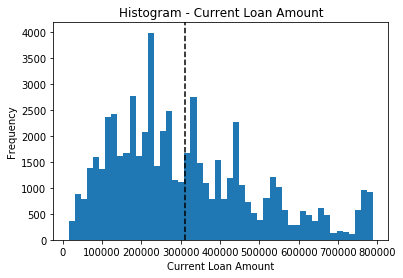

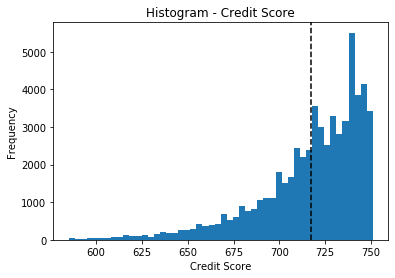

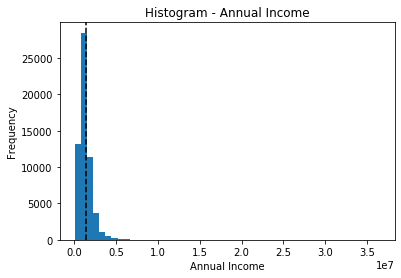

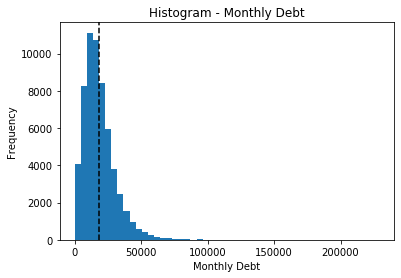

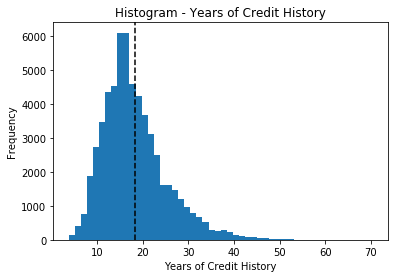

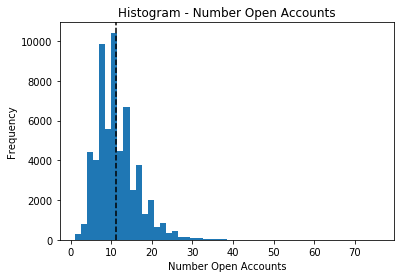

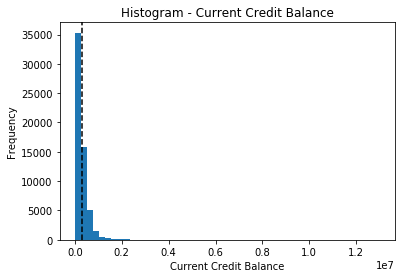

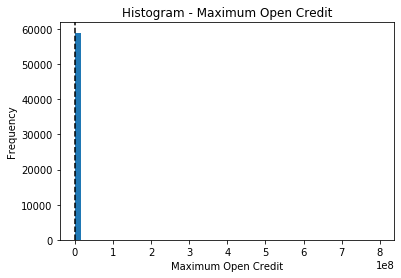

In [59]:
numeric = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 
           'Number Open Accounts', 'Current Credit Balance', 'Maximum Open Credit']

for items in numeric:
    df[items].plot(kind='hist', bins=50)
    plt.title('Histogram - {}'.format(items))
    plt.xlabel ('{}'.format(items))
    plt.axvline(df[items].mean(), color='k', linestyle='dashed', linewidth=1.5)
    plt.show()

### 5.2 Correlation Between Continuous Features <a name="5.2"></a>

Looking at the correlations between the continuous features, there doesn't seem to be any strongly correlated features, with the highest correlation being 0.56 between 'Monthly Debt' and 'Annual Income', hence multi-collinearity shouldn't be a big issue.

Text(0.5, 1, 'Heatmap of Correlations Between Continuous Features')

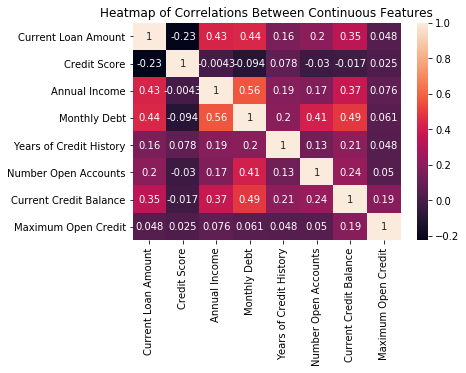

In [60]:
sns.heatmap(df[numeric].corr(),annot=True)
plt.title('Heatmap of Correlations Between Continuous Features')

### 5.3 Credit Score By Loan Status <a name="5.3"></a>

When comparing credit score by loan status, fully paid borrowers on average have a higher credit score compared to borrowers who were charged off.

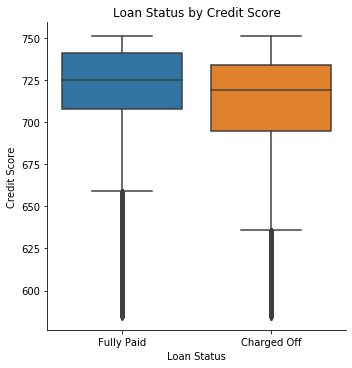

In [61]:
sns.catplot(x='Loan Status', y='Credit Score', kind='box', data=df)
plt.title('Loan Status by Credit Score')
plt.show()

This is broken down further to include home ownership status. The boxplots below indicate that borrowers with mortgages tend to have the highest credit score for both fully paid and charged off. Additionally, home owners and renters had similar credit scores when fully paid, while renters had the lowest credit score when charged off. 

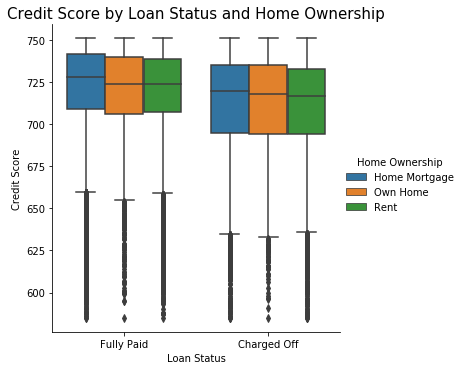

In [62]:
sns.catplot(x='Loan Status',y='Credit Score',hue='Home Ownership',kind='box',data=df)
plt.title('Credit Score by Loan Status and Home Ownership', fontsize = 15)
plt.show()

### 5.4 Current Loan Amount By Loan Status <a name="5.4"></a>

When comparing loan amount by loan status, fully paid borrowers on average have a lower loan amount compared to borrowers who have a high loan amount.

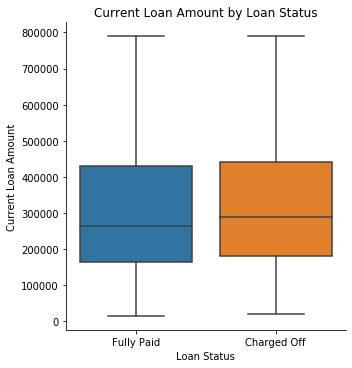

In [63]:
sns.catplot(x='Loan Status', y='Current Loan Amount', kind='box', data=df)
plt.title('Current Loan Amount by Loan Status')
plt.show()

Dividing the plot further with credit problems show that borrowers with credit problems tend to have a lower loan amount for both fully paid and charged off, which makes sense as credit problems would generally lead to more restrictions on borrowing.

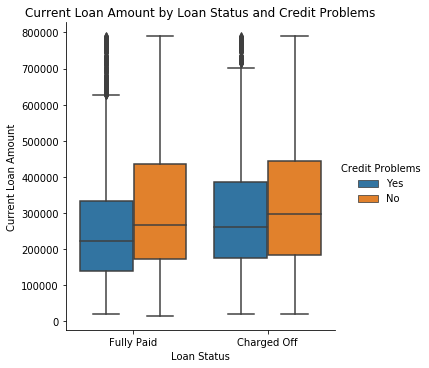

In [64]:
sns.catplot(x='Loan Status', y='Current Loan Amount', hue='Credit Problems', kind='box', data=df)
plt.title('Current Loan Amount by Loan Status and Credit Problems')
plt.show()

### 5.5 Years Of Credit History By Loan Status <a name="5.5"></a>

When comparing years of credit history by loan status, there doesn't seem to be a major difference in averages. However, charged off borrowers do have slightly less years of credit history compared to fully paid borrowers.

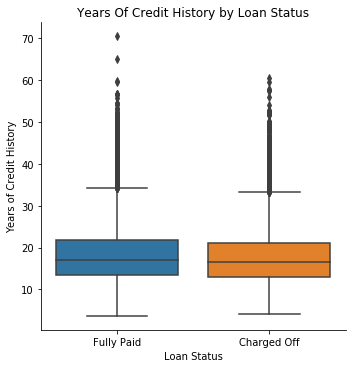

In [65]:
sns.catplot(x='Loan Status', y='Years of Credit History', kind='box', data=df)
plt.title('Years Of Credit History by Loan Status')
plt.show()

When dividing this further by the number of years in current job, it can be seen that `10+ years` tend to have longer years of credit history for both charged off and fully paid, which makes sense given that the longer someone works, the older they probably are. What's interesting however, is that `Not Applicable` has the highest mean of credit history years.

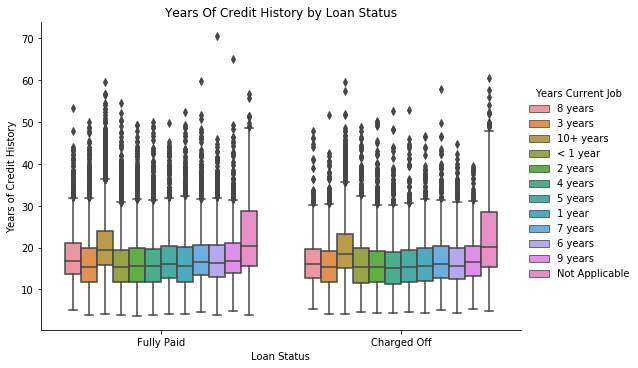

In [66]:
sns.catplot(x='Loan Status', y='Years of Credit History', hue='Years Current Job', kind='box', data=df,
            orient="v", height=5, aspect=1.5)
plt.title('Years Of Credit History by Loan Status')
plt.show()

### 5.6 Monthly Debt by Loan Status and Home Ownership <a name="5.6"></a>

When comparing monthly debt by loan status and home ownership, it can be seen that charged off has slightly higher means of monthly debt for all home ownership statuses. For both charged off and fully paid, `Home Mortgage` has the highest mean for monthly debt, while `Rent` has the lowest.

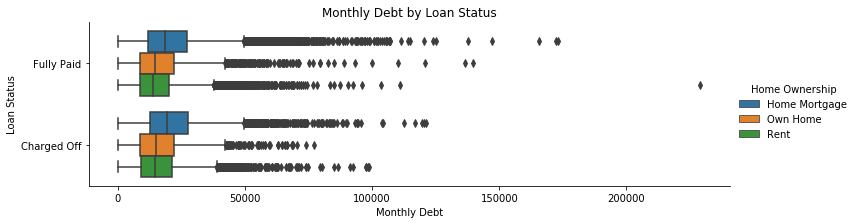

In [67]:
sns.catplot(x='Monthly Debt', y='Loan Status', hue='Home Ownership', kind='box', data=df, 
            orient="h", height=3, aspect=3.5)
plt.title('Monthly Debt by Loan Status')
plt.show()

### 5.7 Loan Term by Loan Status <a name="5.7"></a>

When comparing loan status and loan term, it seems that there is a higher proportion of long term loans for those who have been charged off compared to those that fully paid. This suggests that borrowers tend to not meet their loan obligations when the repayment period is longer (which usually means a larger loan).

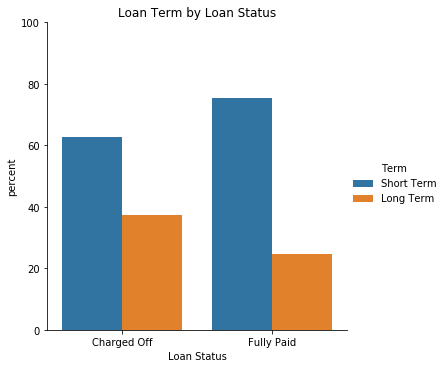

In [68]:
x,y = 'Loan Status', 'Term'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x=x, y='percent', hue=y, kind='bar')).set(ylim = (0, 100))
plt.title('Loan Term by Loan Status')
plt.show()

## 6. Data Encoding <a name="6"></a>

The `df` dataset will be split between the descriptive feature (`data`) and the target feature (`target`).

In [69]:
data = df.drop(columns='Loan Status')
target = df['Loan Status']

print("data shape:", data.shape)
print("target shape:", target.shape)

data shape: (59021, 16)
target shape: (59021,)


### 6.1 Target Feature <a name="6.1"></a>

The target feature will be encoded with the 'Charged Off' level being `0` and the 'Fully Paid' level being `1`. Note that the target feature's classes are imbalanced.

In [70]:
target = target.replace({'Charged Off': 0, 'Fully Paid': 1})
target.value_counts()

1    41853
0    17168
Name: Loan Status, dtype: int64

Additionally, the target feature will be converted into a numpy array for Scikit-Learn.

In [71]:
target = np.array(target)
type(target)

numpy.ndarray

### 6.2 Categorical Features <a name="6.2"></a>

All categorical features in the dataset are nominal (including 'Years Current Job', which was determined to be nominal in section 4.5.6), hence will be one-hot encoded as either `0` or `1` if binary, or encoded as dummy features if multinomial.

In [72]:
cat_var = data.columns[data.dtypes==object].tolist()
cat_var

['Term',
 'Years Current Job',
 'Home Ownership',
 'Purpose',
 'Has Been Delinquent',
 'Credit Problems',
 'Bankruptcies',
 'Tax Liens']

In [73]:
for i in cat_var:
    n = len(data[i].unique())
    if (n == 2):
        data[i] = pd.get_dummies(data[i], drop_first=True)
    
data = pd.get_dummies(data)

Once the categorical features are encoded, there are 35 descriptive features in total.

In [74]:
data.head(5)

,Current Loan Amount,Term,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Has Been Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Years Current Job_1 year,Years Current Job_10+ years,Years Current Job_2 years,Years Current Job_3 years,Years Current Job_4 years,Years Current Job_5 years,Years Current Job_6 years,Years Current Job_7 years,Years Current Job_8 years,Years Current Job_9 years,Years Current Job_< 1 year,Years Current Job_Not Applicable,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Car/Education,Purpose_Debt/MajorPurchase,Purpose_HomeImprove/Wedding,Purpose_House/Other,Purpose_Medical/Energy,Purpose_Move/Business,Purpose_vacation
0,445412.000,1,709.000,1167493.000,5214.740,17.200,0,6.000,1,228190.000,416746.000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
3,347666.000,0,721.000,806949.000,8741.900,12.000,0,9.000,0,256329.000,386958.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,206602.000,1,729.000,896857.000,16367.740,17.300,0,6.000,0,215308.000,272448.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,217646.000,1,730.000,1184194.000,10855.080,19.600,1,13.000,1,122170.000,272052.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
7,548746.000,1,678.000,2559110.000,18660.280,22.600,1,4.000,0,437171.000,555038.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [75]:
print("Shape:", data.shape, "\n")
print("Data Types:")
print(data.dtypes)

Shape: (59021, 35) 

Data Types:
Current Loan Amount                 float64
Term                                  uint8
Credit Score                        float64
Annual Income                       float64
Monthly Debt                        float64
Years of Credit History             float64
Has Been Delinquent                   uint8
Number Open Accounts                float64
Credit Problems                       uint8
Current Credit Balance              float64
Maximum Open Credit                 float64
Bankruptcies                          uint8
Tax Liens                             uint8
Years Current Job_1 year              uint8
Years Current Job_10+ years           uint8
Years Current Job_2 years             uint8
Years Current Job_3 years             uint8
Years Current Job_4 years             uint8
Years Current Job_5 years             uint8
Years Current Job_6 years             uint8
Years Current Job_7 years             uint8
Years Current Job_8 years             uint8

## 7. Data Scaling <a name="7"></a>

The descriptive features are scaled via standardisation.

In [76]:
data_copy = data.copy()

data_scaler = preprocessing.StandardScaler()
data_scaler.fit(data)
data = data_scaler.fit_transform(data)

The normalised `data` dataset is displayed below.

In [77]:
pd.DataFrame(data, columns=data_copy.columns).head(10)

,Current Loan Amount,Term,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Has Been Delinquent,Number Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Years Current Job_1 year,Years Current Job_10+ years,Years Current Job_2 years,Years Current Job_3 years,Years Current Job_4 years,Years Current Job_5 years,Years Current Job_6 years,Years Current Job_7 years,Years Current Job_8 years,Years Current Job_9 years,Years Current Job_< 1 year,Years Current Job_Not Applicable,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Car/Education,Purpose_Debt/MajorPurchase,Purpose_HomeImprove/Wedding,Purpose_House/Other,Purpose_Medical/Energy,Purpose_Move/Business,Purpose_vacation
0,0.722,0.630,-0.286,-0.219,-1.099,-0.140,-0.934,-1.026,2.501,-0.184,-0.065,2.862,-0.140,-0.263,-0.672,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,4.536,-0.202,-0.297,-0.213,1.032,-0.319,-0.857,-0.117,-1.946,4.010,-0.331,-0.106,-0.145,-0.081
1,0.194,-1.588,0.134,-0.617,-0.807,-0.882,-0.934,-0.428,-0.400,-0.105,-0.071,-0.349,-0.140,-0.263,-0.672,-0.317,3.349,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,-0.297,-0.213,-0.969,3.134,-0.857,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
2,-0.568,0.630,0.415,-0.518,-0.174,-0.125,-0.934,-1.026,-0.400,-0.221,-0.095,-0.349,-0.140,-0.263,1.488,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,-0.297,-0.213,1.032,-0.319,-0.857,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
3,-0.508,0.630,0.450,-0.201,-0.631,0.203,1.070,0.371,2.501,-0.485,-0.095,2.862,-0.140,-0.263,-0.672,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,3.363,-0.213,1.032,-0.319,-0.857,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
4,1.280,0.630,-1.373,1.317,0.016,0.631,1.070,-1.426,-0.400,0.408,-0.036,-0.349,-0.140,-0.263,-0.672,3.159,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,-0.297,-0.213,-0.969,-0.319,1.167,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
5,-0.517,0.630,0.765,0.098,1.725,-0.610,-0.934,1.768,-0.400,1.066,0.062,-0.349,-0.140,-0.263,-0.672,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,3.363,-0.213,-0.969,-0.319,1.167,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
6,-0.419,0.630,0.345,-0.743,-0.353,0.931,1.070,-0.228,2.501,-0.751,-0.129,2.862,-0.140,-0.263,1.488,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,-0.297,-0.213,-0.969,-0.319,1.167,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
7,1.914,-1.588,0.204,0.503,-0.071,0.545,1.070,0.770,-0.400,1.475,0.267,-0.349,-0.140,-0.263,1.488,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,-0.220,-0.202,-0.297,-0.213,1.032,-0.319,-0.857,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081
8,0.425,0.630,1.045,0.470,-1.326,0.645,-0.934,-1.026,-0.400,-0.488,0.016,-0.349,-0.140,-0.263,-0.672,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,4.536,-0.202,-0.297,-0.213,1.032,-0.319,-0.857,-0.117,-1.946,4.010,-0.331,-0.106,-0.145,-0.081
9,0.029,-1.588,-1.057,-0.257,-0.733,-0.111,1.070,-1.426,-0.400,-0.660,-0.125,-0.349,-0.140,-0.263,-0.672,-0.317,-0.299,-0.254,-0.270,-0.245,-0.243,4.536,-0.202,-0.297,-0.213,-0.969,-0.319,1.167,-0.117,0.514,-0.249,-0.331,-0.106,-0.145,-0.081


Check that both the `target` and `data` sets are numpy arrays.

In [78]:
print("data:", type(data))
print("target:", type(target))

data: <class 'numpy.ndarray'>
target: <class 'numpy.ndarray'>


## 8. Sampling & Train/Test Splitting <a name="8"></a>

Since the dataset contain 59,021 observations, a smaller sample of 10,000 will be taken for the purpose of faster computation time. The sampled datasets are named `data_sample` and `target_sample`.

In [79]:
n_samples = 10000

data_sample = pd.DataFrame(data).sample(n=n_samples, random_state=888).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=888).values

print(data_sample.shape)
print(target_sample.shape)

(10000, 35)
(10000, 1)


The `data_sample` and `target_sample` sets are split 70/30 for the respective training and testing sets.

In [80]:
d_train, d_test, t_train, t_test = train_test_split(data_sample, 
                                                    target_sample, 
                                                    test_size=0.3,
                                                    random_state=888,
                                                    shuffle=True,
                                                    stratify=target_sample)

print("Data Training Shape:", d_train.shape)
print("Data Testing Shape:", d_test.shape)
print("Target Training Shape:", t_train.shape)
print("Target Testing Shape:", t_test.shape)

Data Training Shape: (7000, 35)
Data Testing Shape: (3000, 35)
Target Training Shape: (7000, 1)
Target Testing Shape: (3000, 1)


## 9. Hyperparameter & Feature Selection <a name="9"></a>

For finding the optimal hyper-parameters, stratified k-fold cross validation will be used (with 5 folds and 2 repeats) as to account for the class imbalance of the target feature. Since this project is a binary classification problem with class imbalance, Area Under the ROC Curve (AUC) will be used as the metric to determine the accuracy of each machine learning algorithm. The classification algorithms used are:
- K-Nearest Neighbours (KNN).
- Decision Tree (DT).
- Naive Bayes (NB).
- Logistic Regression (LR)
- Random Forest (RF).

The feature selection will be done via Random Forest Importance (RFI) using 100 estimators, which will be implemented into the pipeline when searching for each classifier's optimal hyper-parameters. The code chunks below allows RFI to be implemented into the pipeline process as well as defining a function to return the ranked order of each hyper-parameter/feature selection combination. These codes are provided by Vurul Aksakalli (Aksakalli, V (n.d)).

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

class RFIFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100, random_state=888)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 

    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [82]:
def get_search_results(gs):
    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})
    models = []
    scores = []
    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))
    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))
    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)
    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]
    return pipe_results[columns]

In [83]:
scoring_method = 'roc_auc'
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=888) 

Before searching for the optimal hyper-parameters, the full dataset's feature ranks (obtained via RFI) are examined to get an idea of which features are the most important. The bar chart below indicates that 'Annual Income', 'Current Loan Amount', and 'Monthly Debt' are the top three most important features. It can also be observed that the importance values fall significantly after 'Number Open Accounts'.

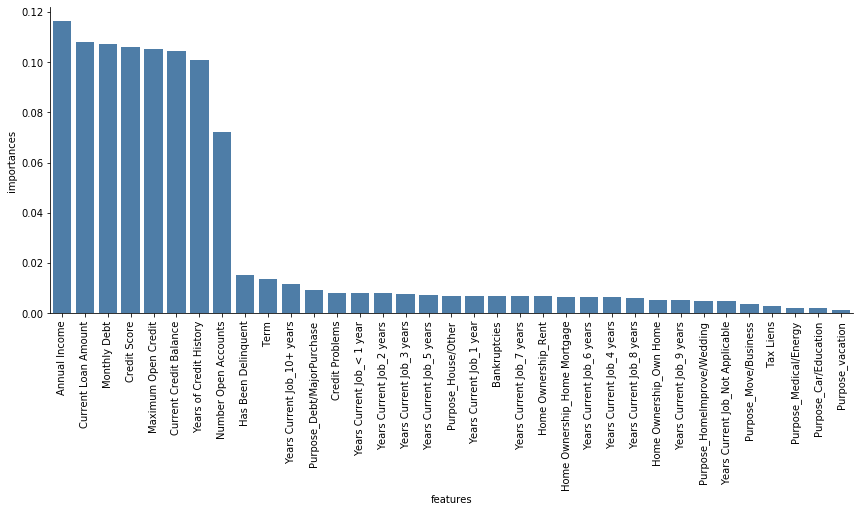

In [84]:
num_features = len(data)

model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = data_copy.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

imp = pd.DataFrame({'features': best_features_rfi, 
                    'importances': feature_importances_rfi})

chart = sns.catplot(x='features', 
                    y='importances', 
                    palette=["#3F7EB6"],
                    kind='bar',
                    data=imp).set_xticklabels(rotation=90)
chart.fig.set_size_inches(16,5)

### 9.1 K-Nearest Neighbours <a name="9.1"></a>

The hyper-parameters chosen for KNN are as follows:
- k: 20, 40, 60, 80, 100.
- p: 1 (Manhattan), 2 (Euclidean).
- Weights: Unweighted, Weighted.
- Features: 10, 20, and 35 (the total number of descriptive features).

In [85]:
pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, data.shape[1]],
                   'knn__n_neighbors': [20, 40, 60, 80, 100],
                   'knn__p': [1, 2],
                   'knn__weights': ['uniform', 'distance']}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           scoring=scoring_method,
                           refit=True,
                           verbose=0,
                           n_jobs=-1) 

gs_pipe_KNN.fit(d_train, t_train);

In [86]:
print("Optimal Hyperparameters For KNN:", gs_pipe_KNN.best_params_, "\n")
print("Optimal AUC Score For KNN:", gs_pipe_KNN.best_score_, "\n")
print("Optimal Estimator For KNN:", gs_pipe_KNN.best_estimator_)

Optimal Hyperparameters For KNN: {'knn__n_neighbors': 100, 'knn__p': 1, 'knn__weights': 'distance', 'rfi_fs__n_features_': 10} 

Optimal AUC Score For KNN: 0.6084777443307762 

Optimal Estimator For KNN: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=10)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=100, p=1,
                                      weights='distance'))],
         verbose=False)


Top five optimal hyper-parameter combinations:

In [87]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head(5)

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,knn__weights,rfi_fs__n_features_
51,0.608,0.013,0.625,0.579,100,1,distance,10
48,0.608,0.012,0.624,0.579,100,1,uniform,10
57,0.607,0.013,0.622,0.574,100,2,distance,10
39,0.606,0.013,0.626,0.575,80,1,distance,10
36,0.606,0.013,0.626,0.576,80,1,uniform,10


The best KNN hyper-parameter was found using 10 features, 100 neighbours, Manhattan distance (p = 1), and weighting the points by the inverse of their distance. This model has an AUC score of 0.608. 

Looking at the optimal hyper-parameter combination, it performed best with 10 features, hence the KNN hyper-parameters are plotted below given that 10 features are used. The plot indicates that the local maxima has not been reached since the AUC score keeps increasing with higher k values.

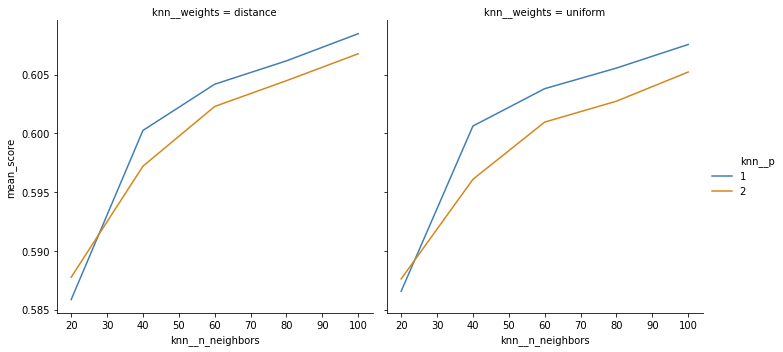

In [88]:
results_KNN_10_features  = results_KNN[results_KNN['rfi_fs__n_features_'] == 10.0]
results_KNN_10_features['mean_score'] = results_KNN_10_features['mean_score'].astype(float)
results_KNN_10_features['knn__n_neighbors'] = results_KNN_10_features['knn__n_neighbors'].astype(int)
results_KNN_10_features['knn__p'] = results_KNN_10_features['knn__p'].astype(int)

knn = sns.relplot(x='knn__n_neighbors', 
                  y='mean_score', 
                  hue='knn__p', 
                  col='knn__weights', 
                  palette=["#3F7EB6", "#D6861A"],
                  kind='line', 
                  data=results_KNN_10_features)

The KNN hyper-parameter grid space is searched again, this time with k values being: 200, 250, 300, 350, 400.

In [89]:
pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, data.shape[1]],
                   'knn__n_neighbors': [200, 250, 300, 350, 400],
                   'knn__p': [1, 2],
                   'knn__weights': ['uniform', 'distance']}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           scoring=scoring_method,
                           refit=True,
                           verbose=0,
                           n_jobs=-1) 

gs_pipe_KNN.fit(d_train, t_train);

In [90]:
print("Optimal Hyperparameters For KNN:", gs_pipe_KNN.best_params_, "\n")
print("Optimal AUC Score For KNN:", gs_pipe_KNN.best_score_, "\n")
print("Optimal Estimator For KNN:", gs_pipe_KNN.best_estimator_)

Optimal Hyperparameters For KNN: {'knn__n_neighbors': 300, 'knn__p': 1, 'knn__weights': 'distance', 'rfi_fs__n_features_': 10} 

Optimal AUC Score For KNN: 0.6196732369564154 

Optimal Estimator For KNN: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=10)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=300, p=1,
                                      weights='distance'))],
         verbose=False)


Top five optimal hyper-parameter combinations:

In [91]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head(5)

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,knn__weights,rfi_fs__n_features_
27,0.620,0.010,0.630,0.594,300,1,distance,10
24,0.620,0.009,0.629,0.596,300,1,uniform,10
39,0.620,0.012,0.634,0.592,350,1,distance,10
36,0.619,0.012,0.634,0.592,350,1,uniform,10
51,0.619,0.010,0.630,0.595,400,1,distance,10


A new optimal value for k is found to be 300, with a new AUC score of 0.620, which was an increase from the first model found.

Looking at the optimal hyper-parameter combination, it performed best with 10 features, hence the KNN hyper-parameters are plotted below given that 10 features are used. This time, the plot indicates a local maxima.

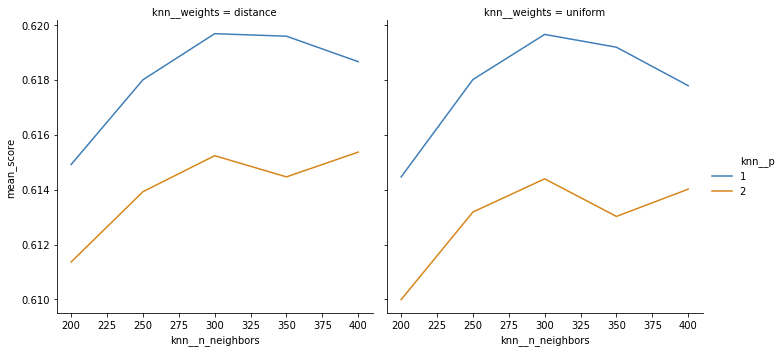

In [92]:
results_KNN_10_features  = results_KNN[results_KNN['rfi_fs__n_features_'] == 10.0]
results_KNN_10_features['mean_score'] = results_KNN_10_features['mean_score'].astype(float)
results_KNN_10_features['knn__n_neighbors'] = results_KNN_10_features['knn__n_neighbors'].astype(int)
results_KNN_10_features['knn__p'] = results_KNN_10_features['knn__p'].astype(int)

knn = sns.relplot(x='knn__n_neighbors', 
                  y='mean_score', 
                  hue='knn__p', 
                  col='knn__weights', 
                  palette=["#3F7EB6", "#D6861A"],
                  kind='line', 
                  data=results_KNN_10_features)

### 9.2 Decision Tree <a name="9.2"></a>

The hyper-parameters chosen for DT are as follows:
- Maximum Depth: 3, 5, 10, 15, 20.
- Minimum Samples Split: 2, 5, 7, 9, 11.
- Criterion: Entropy, Gini Index.
- Features: 10, 20 , full set (35).

In [93]:
pipe_DT = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                          ('dt', DecisionTreeClassifier())])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, data.shape[1]],
                  'dt__max_depth': [3, 5, 10, 15, 20],
                  'dt__min_samples_split': [2, 5, 7, 9, 11],
                  'dt__criterion': ['gini', 'entropy']}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          scoring=scoring_method,
                          refit=True,
                          verbose=0,
                          n_jobs=-1) 

gs_pipe_DT.fit(d_train, t_train);

In [94]:
print("Optimal Hyperparameters For DT:", gs_pipe_DT.best_params_, "\n")
print("Optimal AUC Score For DT:", gs_pipe_DT.best_score_, "\n")
print("Optimal Estimator For DT:", gs_pipe_DT.best_estimator_)

Optimal Hyperparameters For DT: {'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_split': 2, 'rfi_fs__n_features_': 10} 

Optimal AUC Score For DT: 0.6011118435635406 

Optimal Estimator For DT: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=10)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)


Top five optimal hyper-parameter combinations:

In [95]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head(5)

,mean_score,std_score,max_score,min_score,dt__criterion,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
0,0.601,0.006,0.609,0.589,gini,3,2,10
8,0.601,0.006,0.609,0.589,gini,3,7,35
14,0.601,0.006,0.609,0.589,gini,3,11,35
13,0.601,0.006,0.609,0.589,gini,3,11,20
12,0.601,0.006,0.609,0.589,gini,3,11,10


The DT with the best score of 0.601 was found using the Gini index to maximize information gain with a maximum depth of 3 and a minimum sample split of 2, using 10 features. 

Since it performed best with 10 features, the DT hyper-parameters are plotted below given that 10 features are used. It can be seen that on the Gini Index plot (left), the light blue line seems to be flat without any obvious increase in value, meaning that there isn't much change in ROC score given changes in minimum samples split.

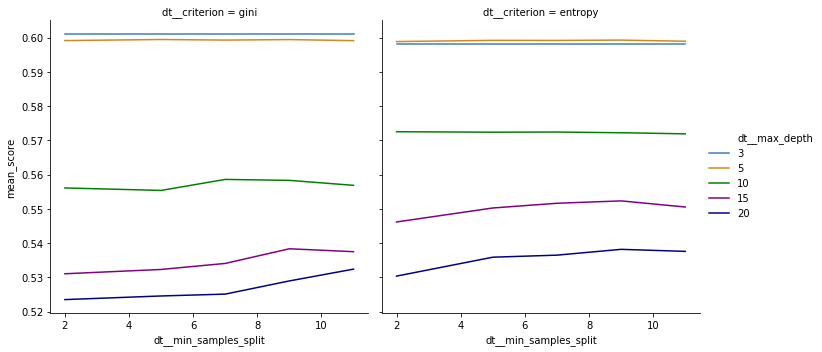

In [96]:
results_DT_10_features  = results_DT[results_DT['rfi_fs__n_features_'] == 10.0]
results_DT_10_features['mean_score'] = results_DT_10_features['mean_score'].astype(float)
results_DT_10_features['dt__min_samples_split'] =results_DT_10_features['dt__min_samples_split'].astype(int)
results_DT_10_features['dt__max_depth'] =results_DT_10_features['dt__max_depth'].astype(int)

dt = sns.relplot(x='dt__min_samples_split', 
                 y='mean_score', 
                 hue='dt__max_depth', 
                 col='dt__criterion', 
                 palette=["#3F7EB6", "#D6861A", "g", "purple", "navy"], 
                 kind='line', 
                 data=results_DT_10_features)

### 9.3 Naïve Bayes <a name="9.3"></a>

The hyper-parameter for NB is the variance smoothing, where 50 randomly chosen values from 200 different values created within a logspace between -2 and 2 are used. As some of the features were not normally distributed as shown in the data exploration and visualisation, a power transformation is applied to the descriptive features.

In [97]:
d_train_transformed = PowerTransformer().fit_transform(d_train)

In [98]:
pipe_NB = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                          ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, data.shape[1]],
                  'nb__var_smoothing': np.logspace(2, -2, num = 200)}

gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                                param_distributions=params_pipe_NB, 
                                cv=cv_method,
                                scoring=scoring_method,
                                n_iter = 50,
                                refit=True,
                                verbose=0,
                                n_jobs=-1) 

gs_pipe_NB.fit(d_train_transformed, t_train);

In [99]:
print("Optimal Hyperparameters For NB:", gs_pipe_NB.best_params_, "\n")
print("Optimal AUC Score For NB:", gs_pipe_NB.best_score_, "\n")
print("Optimal Estimator For NB:", gs_pipe_NB.best_estimator_)

Optimal Hyperparameters For NB: {'rfi_fs__n_features_': 10, 'nb__var_smoothing': 0.29331662783900453} 

Optimal AUC Score For NB: 0.6241531694878792 

Optimal Estimator For NB: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=10)),
                ('nb',
                 GaussianNB(priors=None, var_smoothing=0.29331662783900453))],
         verbose=False)


Top five optimal hyper-parameter combinations:

In [100]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head(5)

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
27,0.624,0.008,0.635,0.608,10.000,0.293
0,0.624,0.008,0.636,0.610,10.000,0.707
16,0.624,0.008,0.633,0.607,10.000,0.128
18,0.624,0.008,0.633,0.607,10.000,0.116
5,0.624,0.008,0.633,0.607,10.000,0.111


The optimal value of the hyper-parameter for NB is found to be a variance smoothing of 0.293 resulting in an AUC score of 0.624 using 10 features.

Since it performed best with 10 features, the NB hyper-parameter is plotted below given that 10 features are used. The plot indicates that the optimal score is around the local maxima.

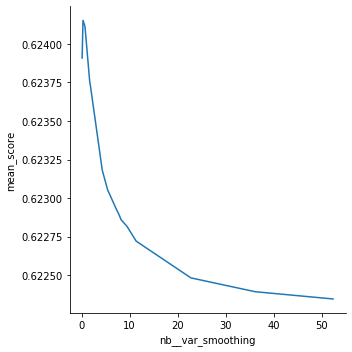

In [101]:
results_NB_10_features  = results_NB[results_NB['rfi_fs__n_features_'] == 10.0]
results_NB_10_features['mean_score'] = results_NB_10_features['mean_score'].astype(float)
results_NB_10_features['nb__var_smoothing'] = results_NB_10_features['nb__var_smoothing'].astype(float)

knn = sns.relplot(x='nb__var_smoothing' , y='mean_score',kind='line', data=results_NB_10_features)

### 9.4 Logistic Regression <a name="9.4"></a>

The hyper-parameters used for LR are as follows:
- Penalty: L1, L2. 
- Features: 10, 15, 20, 25, full set (35).

In [102]:
pipe_LR = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                          ('lr', LogisticRegression(solver='saga'))])

params_pipe_LR = {'rfi_fs__n_features_': [10, 15, 20, 25, data.shape[1]],
                  'lr__penalty': ['l1', 'l2']}

gs_pipe_LR = GridSearchCV(estimator=pipe_LR, 
                          param_grid=params_pipe_LR, 
                          cv=cv_method,
                          scoring=scoring_method,
                          refit=True,
                          verbose=0,
                          n_jobs=-1) 

gs_pipe_LR.fit(d_train, t_train);

In [103]:
print("Optimal Features For LR:", gs_pipe_LR.best_params_, "\n")
print("Optimal AUC Score For LR:", gs_pipe_LR.best_score_, "\n")
print("Optimal Estimator For LR:", gs_pipe_LR.best_estimator_)

Optimal Features For LR: {'lr__penalty': 'l1', 'rfi_fs__n_features_': 15} 

Optimal AUC Score For LR: 0.6359323632200623 

Optimal Estimator For LR: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=15)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


Top five optimal hyper-parameter combinations:

In [104]:
results_LR = get_search_results(gs_pipe_LR)
results_LR.head(5)

,mean_score,std_score,max_score,min_score,lr__penalty,rfi_fs__n_features_
1,0.636,0.006,0.646,0.627,l1,15
6,0.636,0.006,0.646,0.626,l2,15
0,0.634,0.008,0.647,0.623,l1,10
5,0.634,0.008,0.647,0.623,l2,10
2,0.634,0.007,0.646,0.622,l1,20


The optimal LR model has an AUC score of 0.636 with an L1 penalty and using 15 features.

The plot below indicates that the optimal score (15 features) is around the local maximum.

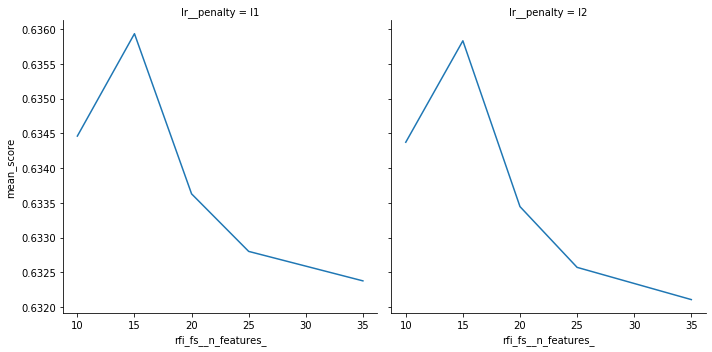

In [105]:
results_LR['rfi_fs__n_features_']  = results_LR['rfi_fs__n_features_'].astype(int)
results_LR['mean_score'] = results_LR['mean_score'].astype(float)

lr = sns.relplot(x='rfi_fs__n_features_', 
                 y='mean_score', 
                 col='lr__penalty', 
                 palette=["b"], 
                 kind='line', 
                 data=results_LR)

### 9.5 Random Forest <a name="9.5"></a>

The hyper-parameter used for RF are the number of estimators, which are chosen to be 100, 200, 300, 400, and 500.

In [106]:
pipe_RF = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                          ('rf', RandomForestClassifier())])

params_pipe_RF = {'rfi_fs__n_features_': [10, 20, data.shape[1]],
                  'rf__n_estimators': [100, 200, 300, 400, 500]}

gs_pipe_RF = GridSearchCV(estimator=pipe_RF, 
                          param_grid=params_pipe_RF, 
                          cv=cv_method,
                          scoring=scoring_method,
                          refit=True,
                          verbose=0,
                          n_jobs=-1) 

gs_pipe_RF.fit(d_train, t_train);

In [107]:
print("Optimal Features For RF:", gs_pipe_RF.best_params_, "\n")
print("Optimal AUC Score For RF:", gs_pipe_RF.best_score_, "\n")
print("Optimal Estimator For RF:", gs_pipe_RF.best_estimator_)

Optimal Features For RF: {'rf__n_estimators': 200, 'rfi_fs__n_features_': 35} 

Optimal AUC Score For RF: 0.6140571561556454 

Optimal Estimator For RF: Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=35)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
    

Top five optimal hyper-parameter combinations:

In [108]:
results_RF = get_search_results(gs_pipe_RF)
results_RF.head(5)

,mean_score,std_score,max_score,min_score,rf__n_estimators,rfi_fs__n_features_
5,0.614,0.009,0.624,0.596,200.000,35.000
10,0.611,0.008,0.624,0.599,400.000,20.000
11,0.611,0.008,0.619,0.593,400.000,35.000
14,0.611,0.005,0.618,0.600,500.000,35.000
8,0.610,0.008,0.624,0.595,300.000,35.000


The optimal RF is found with 200 estimators and 35 features, which returns an AUC score of 0.614.

Looking at the optimal hyper-parameter combination, it performed best with 35 features, hence the RF hyper-parameter is plotted below given that 35 features are used. The plot indicates that the optimal score is around the local maxima.

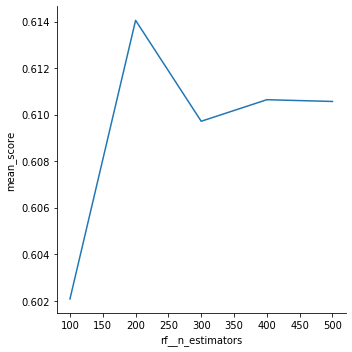

In [109]:
results_RF_35_features  = results_RF[results_RF['rfi_fs__n_features_'] == 35.0]
results_RF_35_features['mean_score'] = results_RF_35_features['mean_score'].astype(float)
results_RF_35_features['rf__n_estimators'] = results_RF_35_features['rf__n_estimators'].astype(float)

rf = sns.relplot(x='rf__n_estimators' , 
                 y='mean_score',
                 kind='line', 
                 data=results_RF_35_features)

## 10. Model Evaluation & Comparison <a name="10"></a>

Now that the optimal hyper-parameters and features have been determined for each algorithm via the training set, they are tested on the testing set in a stratified cross-validated fashion (with 10 splits, and 3 repeats) to see how they perform. The metric used to determine accuracy is still the AUC score.

In [110]:
cv_method_ttest = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=888)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=d_test,
                                 y=t_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-1,
                                 scoring='roc_auc')

cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-1,
                                scoring='roc_auc')

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-1,
                                scoring='roc_auc')

cv_results_LR = cross_val_score(estimator=gs_pipe_LR.best_estimator_,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-1,
                                scoring='roc_auc')

cv_results_RF = cross_val_score(estimator=gs_pipe_RF.best_estimator_,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-1,
                                scoring='roc_auc')

print("KNN AUC:", cv_results_KNN.mean().round(3))
print("DT AUC:", cv_results_DT.mean().round(3))
print("NB AUC:", cv_results_NB.mean().round(3))
print("LR AUC:", cv_results_LR.mean().round(3))
print("RF AUC:", cv_results_RF.mean().round(3))

KNN AUC: 0.626
DT AUC: 0.587
NB AUC: 0.61
LR AUC: 0.632
RF AUC: 0.611


At first glance, it appears that the logistic regression performed the best out of the five algorithms based on the ROC AUC performance scores calculated. While these performance scores were all within 5% of each other, a paired sample t-test is performed to determine whether these differences between the models are statistically significant. Pairing is done through use of fixing the same seed during cross-validation, therefore all the tuned classifiers are fitted and tested on the same data partitions. 

Inspection of the returned p-values indicate that there is no statistically significant difference between LR and KNN. However, p-values of less than the significance level of 0.01 are returned for the difference between LR and DT, NB, and RF, meaning the differences here are significant. Therefore, the best overall classifiers to use to predict loan status based on ROC AUC score are Logistic Regression or K-Nearest Neighbours. 

In [111]:
print("LR is the same as KNN p-value:", stats.ttest_rel(cv_results_LR, cv_results_KNN).pvalue.round(4))
print("LR is the same as DT p-value:", stats.ttest_rel(cv_results_LR, cv_results_DT).pvalue.round(4))
print("LR is the same as NB p-value:", stats.ttest_rel(cv_results_LR, cv_results_NB).pvalue.round(4))
print("LR is the same as RF p-value:", stats.ttest_rel(cv_results_LR, cv_results_RF).pvalue.round(4))

LR is the same as KNN p-value: 0.2268
LR is the same as DT p-value: 0.0
LR is the same as NB p-value: 0.0
LR is the same as RF p-value: 0.002


# 11. Discussion <a name="11"></a>

One limitation of the study was that only the ROC area under the curve performance score was used as a comparison across models. As the data was regarding lending, perhaps from the point of view of the lending institution, recall or true positive rate may have been a more preferable performance metric to better identify applicants that will fully pay off their loans. This also depends on the lending institution's profit matrix. Similar comparisons of the tuned classifiers could be made in the future. 

Another consideration was computation. As the present dataset was relatively large, performing the cross-validations and repetitions for each hyper-parameter/feature set combination would've taken a considerable amount of time to compute, hence only a small sample was used. It might be worth examining if changing some of these cross validation parameters or working with a smaller or larger subset of the overall data would have a drastic change on the overall performance and hyper-parameter tuning of the classifiers. Additionally, more fine tuning on the hyper-parameter searching is possible given more time and/or computing power as all hyper-parameter values entered into the grid search were quite coarse. Once an optimal hyper-parameter combination is found, it's possible to zone in and break down the grid search parameters into finer values. 

One strength of this study was the stratified cross-validation method used to deal with the imbalanced target feature. Additionally, the thorough pre-processing ensured a relatively clean dataset given the amount of information that was available, that will be ready to be used in the future and in replicating the process. However, it is also important to note that the background information and the descriptions of each feature were not provided, hence a few assumptions had to be made during the pre-processing stage. Furthermore, many assumptions were also *not* made during the pre-processing stage - especially for the extreme outliers of a few continuous features - since without any knowledge or information on these features, it was unreasonable to deal with them as it might have lead to introducing bias into the dataset. That being said, it is also possible that these extreme outliers were in fact errors, which would also introduce problems. Digging further into finding the descriptions for the dataset would benefit this project greatly in the future.

# 12. Conclusion <a name="12"></a>

This purpose of this project was to find the best classifier and its optimal hyper-parameters to predict borrower loan status from the “Bank Loan Status Dataset”. The dataset was pre-processed to deal with missing values, errors, redundant features, and aggregation, before the categorical descriptive features were one-hot encoded and the entire descriptive feature-set standardised. A random sample of 10,000 observations was then taken from the full dataset which was then divided 70/30 for the training and test datasets. 

The five classifiers chosen were K-nearest neighbours, decision trees, Naive Bayes, logistic regression, and random forests. Each classifier's hyper-paramters and best feature selection (found with random forest importance) were tuned on the training dataset by finding the best combination of hyper-parameter values using a grid search with 5-fold cross-validation and 2 repeats. The accuracy metric was measured via the AUC score. The classifiers with their respective optimal hyper-parameters were then fitted on the test set using 10-fold cross-validation with 3 repetitions to see which classifier performed the best. Paired t-tests were then conducted on the best classifier models to determine any statistically significant difference. 

In conclusion, the Logistic Regression model with an L1 penalty and using the 15 best features was found to have the highest cross-validated ROC AUC performance score of 0.632, which significantly outperformed Decision Tree, Naïve Bayes, and Random Forest models at the 0.01 significance level. However, no such significant difference was found between the optimal logistic regression model and the optimal K-nearest neighbour model which had 300 neighbours, Manhattan distance, distanced weighting, and 10 features selected, with respect to the AUC score. 

# References

- Begiev, Z. (2017). Bank Loan Status Dataset: Future Loan Status Prediction via Classification Models[Dataset]. Retrieved from https://www.kaggle.com/zaurbegiev/my-dataset.


- Aksakalli, V. (n.d.) Feature Selection and Ranking in Machine Learning. Retrieved May 26, 2020, from https://www.featureranking.com/.